<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/single_input/prediccion_energia_evento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para la predicción de la energía de un evento, vamos a entrenar una red neuronal a la que le metemos las imágenes del evento, la procesamos un poco con CNN y luego una red densa que termina en 1 neurona que devuelve el valor de energía.
La entrenaremos reduciendo el error cuadratico medio del loss.

Lo primero que necesito es tener los archivos npy pero sin la normalización de la intensidad, no modificamos los valores.

# Definiciones, librerias... Ejecutar lo primero

In [ ]:
#importamos las librerias 
import matplotlib.pyplot as plt 
import numpy as np
import os 
import glob
import re
import pandas as pd
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import heapq

In [ ]:
#directorios 
base_dir="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Prediccion_energia_evento"
npy_sin_norm="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Prediccion_energia_evento/npy_sin_normalizar_y_energias"
npy_sin_norm_auxiliar="/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Prediccion_energia_evento/auxiliar_npy_sin_normalizar_y_energias"
txt_dir="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/gamma_txt"
dt_dir="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/gamma/gamma_dt"


# Funciones para manipular los datos y crear los .npy




In [ ]:
#CONOCER LAS VARIABLES DEFINIDAS Y SUS PESOS
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

In [ ]:
#se ha liado y necesitamos los valores de los eventos para cada uno de los array 
#pero ya tenemos los array, vamos a sacar solo los eventos
def get_events(lista_archivos,npy_dir):
    npy_dir_aux=npy_dir
    files_names=lista_archivos
    for j in range(len(files_names)):
        print(j,end="\n")
        nombre_archivo=re.findall("_(tel_[0-9]*_run_\d\d).dt",files_names[j])[0]
        aux_df=pd.read_csv(files_names[j],sep='  ',names=["1","2","3","4","5","6"],engine="python")
        events=aux_df["1"].unique()
        del aux_df
        name_npy_events=os.path.join(npy_dir_aux,f"id_eventos_npy_sinnormal_{nombre_archivo}_gamma.npy")
        np.save(name_npy_events,np.array(events))


In [ ]:
#ahora vamos a hacer una funcion para el tratamiento de los datos de .dt a un .npy con los datos limpios y agrupaditos de una forma mas sencilla.

#tenemos que buscar una forma de que no guardemos archivos npy de mas de un giga (por poner un limite)
from tqdm.notebook import tqdm

def multiple_dt_2_npy(lista_archivos,npy_dir,limit_size=0.35,save_events_id=False):
  #ground_dir es el directorio base para las carpetas o para los archivos
  #npy_dir es el directorio para guardar todosl os .npy juntos, sin fantasia ni carpetas
  #folders=True es que los elementos .dt estan en carpetas
  #limit_size limite de peso en gigas de los .npy, por defecto esat en 350 Mb ó 0.35 Gigas

  #le añadimos la funcion de que cree un archivo que registra el identificador de cada evento, guardado en el mismo orden que las imagenes
    limit_size=limit_size*1e9 # pasamos de gigas a bytes 
    #tenemos que crear el directorio si aun no existe
    npy_dir_aux=npy_dir
    files_names=lista_archivos
    for j in range(len(files_names)):
        contador_nombre=0
        dt_list=[]  
        print(j,end="\n")
        nombre_archivo=re.findall("_(tel_[0-9]*_run_\d\d).dt",files_names[j])[0]
        aux_df=pd.read_csv(files_names[j],sep='  ',names=["1","2","3","4","5","6"],engine="python")
        #ahora la procesamos y la guardamos en un npy
        value_auf=aux_df[['1','3','4','5']].copy()
        del aux_df
        #tenemos que agupar los valores y normalizarlos 
        value_auf["5"].loc[value_auf["5"]<0]=0
        #max_aux=np.amax(value_auf["5"])
        #value_auf["5"]=value_auf["5"]/max_aux
        x_minimo=min(value_auf['3'])
        y_minimo=min(value_auf['4'])
        events=value_auf["1"].unique()
        if j==0: #esto lo hacemos porque todos los evento deben ser iguales del mismo tipo de telescopio, si no no es valido
            num_pix_x=value_auf["3"].unique().size
            num_pix_y=value_auf["4"].unique().size
            ##!!!esto puede dar problemas si resulta que para el primer evento faltan datos o algo...
            auxiliar=value_auf[value_auf["1"]==events[0]][["3","4","5"]].to_numpy()
            #ahora tenemos los datos de los pixeles, podemos obtener lo que ocupa cada pixel
            size_pix_x=np.ceil((max(auxiliar[:,0])-min(auxiliar[:,0]))/(np.unique(auxiliar[:,0]).size-1))
            size_pix_y=np.ceil((max(auxiliar[:,1])-min(auxiliar[:,1]))/(np.unique(auxiliar[:,1]).size-1))
            del auxiliar
        value_auf['3']=value_auf['3'].apply(lambda x: round((x-x_minimo)/size_pix_x))
        value_auf['4']=value_auf['4'].apply(lambda x: round((x-y_minimo)/size_pix_y))
        #event_aux=value_auf["1"].unique()
        for k in tqdm(range(np.shape(events)[0])):
            #cada evento tiene que ponerse en una imagen con sus valores
            array_aux=value_auf.loc[value_auf["1"]==events[k]][["3","4","5"]]
            #lo que vamos a hacer es poner los valores en una matriz creada de antemano y guardar esa matrix
            #esos numeros vienen del maximo y el minimo valor para los pixeles, simplemente shifteamos todo
            matrix_aux=np.zeros((num_pix_x,num_pix_y)) #eran 60-5= 55 y 131-38
            matrix_aux[array_aux["3"].to_numpy(),array_aux["4"].to_numpy()]=array_aux["5"].to_numpy() 
            dt_list.append(matrix_aux)
            if limit_size!=0:
                if (np.array(dt_list).nbytes>limit_size):
                    name_npy=f"{npy_dir_auxf}/aux_npy_sin_norm_{nombre_archivo}_gamma_{contador_nombre}.npy"
                    np.save(name_npy,np.array(dt_list))
                    del dt_list
                    dt_list=[]
                    contador_nombre+=1

        name_npy=f"{npy_dir_aux}/aux_npy_sin_normal_{nombre_archivo}_gamma_{contador_nombre}.npy"
        np.save(name_npy,np.array(dt_list))
        del dt_list
        if save_events_id:
            name_npy_events=f"{npy_dir_aux}/aux_id_eventos_npy_sin_normal_{nombre_archivo}_gamma.npy"
            np.save(name_npy_events,np.array(events))



In [ ]:
def lista_dt(dt_dir):
    return sorted(glob.glob(f"{dt_dir}/*.dt"))
def lista_txt(txt_dir):
    return sorted(glob.glob(f"{txt_dir}/*.dt"))

In [ ]:
#lista de txt y dt 
list_dt=sorted(glob.glob(f"{dt_dir}/*.dt"))
list_txt=sorted(glob.glob(f"{txt_dir}/*.txt"))

In [ ]:
def extract_info_txt(txt_dir,cols=None,cols_order=True):
  #extraer la informacion relevante de un archivo .txt
  #si se le pasan ciertas columnas se devolvera una lista solo con esas columnas
    with open(txt_dir,"r") as file:
        text_aux=file.read()
        a=re.findall(r'@\+[\s\d.-]*\d',text_aux)
        a=[i.replace("@+ ","").split() for i in a]
    if cols is None:
        return np.array(a).astype("float")
    elif type(cols)==list or type(cols)==np.array:
        list_aux=[]
        if cols_order :
            for i in cols:
                list_aux.append(np.array([float(j[i]) for j in a]))
            return np.array(list_aux).astype("float")
        else:
            list_aux=[]
            for i in a:
                list_aux.append(np.array([i[j] for j in cols ]))
            return np.array(list_aux).astype("float")

    else:
        return np.array([float(j[cols]) for j in a]).astype("float")

In [ ]:
#ahora vamos a extraer de los archivos txt la energia y el numero de evento
#de nombre dejamos el telescopio y la run a la que pertenece
for k in list_txt:
    a=re.findall("_(tel_[0-9]*_run_\d\d).txt",k)[0]
    nombre_aux=f"{npy_sin_norm}/event_y_energytev_{a}.npy"
    array_aux=extract_info_txt(k,cols=[0,2],cols_order=False)
    np.save(nombre_aux,array_aux)

In [ ]:
#ahora tenemos que guardar los eventos npy sin normalizar
multiple_dt_2_npy(list_dt,npy_sin_norm_auxiliar,limit_size=0.35,save_events_id=True)


# Cargamos los datos npy

In [ ]:
datos=sorted(glob.glob(f"{npy_sin_norm}/aux_npy*tel_*_run_*.npy"))
labels=sorted(glob.glob(f"{npy_sin_norm}/event*tel_*_run_*.npy"))

In [ ]:
matri=np.load(datos[0])
energ=np.load(labels[0])
suma_inst=[np.sum(i) for i in matri]

In [ ]:
plt.figure(figsize=(19,13))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(matri[i])
    plt.title(f"Evento {energ[i][0]} de energía {energ[i][1]} TeV, \n suma intensidades {suma_inst[i]}",fontsize=14)
plt.tight_layout()

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(13,13))
sns.regplot(energ[:,1],suma_inst,order=1,color="r")#xbins

## FALTAN LABELS EN ALGUNOS DE LOS PUTOS DOCUMENTOS TXT, LO CUAL SIGNIFICA QUE 
## TENEMOS IMAGENES SIN LABELS Y NO ME SALE y no quiero QUE ME DE ERROR
lo que vamos a hacer es coger solo los que tengan igual primera dimension,
luego para arreglar esto en los archivos, tendre que poner que se descarten aquellos eventos que no
esten en ambos lados (imagen, label)

In [ ]:
datos=sorted(glob.glob(f"{npy_sin_norm}/aux_npy*tel_*_run_*.npy"))
labels=sorted(glob.glob(f"{npy_sin_norm}/event*tel_*_run_*.npy"))

In [ ]:
#vamos si las dimensiones estan bien
for i,j in zip(datos,labels):
    dat1=np.load(i)
    lab=np.load(j)
    print(dat1.shape,lab.shape)
    del dat1, lab

In [ ]:
#cargamos los datos

datos=sorted(glob.glob(f"{npy_sin_norm}/aux_npy*tel_*_run_*.npy"))
labels=sorted(glob.glob(f"{npy_sin_norm}/event*tel_*_run_*.npy"))
dat1=np.load(datos[0])
lab=np.load(labels[0])[:,1]*1e3
suma_intensidades=[[np.sum(i) for i in dat1]]
if dat1.shape[0]!= lab.shape[0]:
    print("LAS DIMENSIONES ESTÁN MAL, LA PRIMERA QUE COJAS DEBE ESTAR BIEN")
print(dat1.shape,lab.shape)
for i in range(1,len(datos)):
    aux_dat=np.load(datos[i])
    aux_lab=np.load(labels[i])[:,1]*1e3
    if aux_dat.shape[0]== aux_lab.shape[0]:
        suma_intensidades.append([np.sum(j) for j in aux_dat])
        dat1=np.concatenate((dat1,aux_dat))
        lab=np.concatenate((lab,aux_lab))
        print(len(suma_intensidades),dat1.shape,lab.shape)
    else:
        pass
    del aux_dat, aux_lab
suma_intensidades=np.concatenate(suma_intensidades)
dat=dat1[...,np.newaxis]
del dat1

(1999, 55, 93) (1999,)
2 (3998, 55, 93) (3998,)
3 (5997, 55, 93) (5997,)
4 (7995, 55, 93) (7995,)
5 (9994, 55, 93) (9994,)
6 (11993, 55, 93) (11993,)
7 (13992, 55, 93) (13992,)
8 (15991, 55, 93) (15991,)
9 (17989, 55, 93) (17989,)
10 (19988, 55, 93) (19988,)
11 (21987, 55, 93) (21987,)
12 (23986, 55, 93) (23986,)
13 (25985, 55, 93) (25985,)
14 (27983, 55, 93) (27983,)
15 (29982, 55, 93) (29982,)
16 (31981, 55, 93) (31981,)
17 (33978, 55, 93) (33978,)
18 (35977, 55, 93) (35977,)
19 (37976, 55, 93) (37976,)
20 (39975, 55, 93) (39975,)
21 (41973, 55, 93) (41973,)
22 (43972, 55, 93) (43972,)
23 (45971, 55, 93) (45971,)
24 (47970, 55, 93) (47970,)
25 (49969, 55, 93) (49969,)
26 (51968, 55, 93) (51968,)
27 (53966, 55, 93) (53966,)
28 (55965, 55, 93) (55965,)
29 (57964, 55, 93) (57964,)
30 (59963, 55, 93) (59963,)
31 (61962, 55, 93) (61962,)
32 (63960, 55, 93) (63960,)
33 (65958, 55, 93) (65958,)
34 (67956, 55, 93) (67956,)
35 (69955, 55, 93) (69955,)
36 (71954, 55, 93) (71954,)
37 (73953, 55

## [SOLUCIONADO] Solucionar la diferencia dimensional entre la features y la labels (faltan algunas features a veces)

In [ ]:
#vamos a cargar los numeros de los eventos que vienen con cada imagen del telescopios y compararlo con las 
# de las labels que tambien tienen el evento cargado
labels=sorted(glob.glob(f"{npy_sin_norm}/event*tel_*_run_*.npy"))
event=sorted(glob.glob(f"{npy_sin_norm}/id_eventos*tel_*_run_*.npy"))
if len(labels)!= len(event):
    print("ERROR numero de DOCUMENTOS")
for i in range(len(labels)):
    aux_lab=np.load(labels[i])[:,0]
    aux_event=np.load(event[i])
    for j in aux_event:
        if j not in aux_lab:
            print(j)
    

In [ ]:
for i,j in zip(event,labels):
    dat1=np.load(i)
    lab=np.load(j)
    print(dat1.shape,lab.shape)
    del dat1, lab

(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1998,) (1998, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1998,) (1998, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1998,) (1998, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1997,) (1997, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1998,) (1998, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1998,) (1998, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1998,) (1998, 2)
(1998,) (1998, 2)
(1998,) (1998, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)
(1998,) (1998, 2)
(1999,) (1999, 2)
(1999,) (1999, 2)


# Creamos el modelo 

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(dat,lab,test_size=0.2,random_state=42)
del dat, lab

In [ ]:
#creación de modelo
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64,kernel_size=5,padding="same", input_shape=(55,93,1),activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(32,kernel_size=5,padding="same",activation="relu"))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(16,kernel_size=3,activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(200,activation="relu"))
model.add(tf.keras.layers.Dense(20))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 55, 93, 64)        1664      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 46, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 27, 46, 32)        51232     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 23, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 21, 16)        4624      
_________________________________________________________________
dropout_4 (Dropout)          (None, 11, 21, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3696)             

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(patience=6)
model.compile(optimizer="adam",loss="mse")

# Entrenamos el modelo
Aqui lo vamos a hacer de muchas formas pero sin mucho criterio

## Entrenamiento 1, características...



In [ ]:
#cargamos los datos

datos=sorted(glob.glob(f"{npy_sin_norm}/aux_npy*tel_*_run_*.npy"))
labels=sorted(glob.glob(f"{npy_sin_norm}/event*tel_*_run_*.npy"))
dat1=np.load(datos[0])
lab=np.load(labels[0])[:,1]
suma_intensidades=[[np.sum(i) for i in dat1]]
if dat1.shape[0]!= lab.shape[0]:
    print("LAS DIMENSIONES ESTÁN MAL, LA PRIMERA QUE COJAS DEBE ESTAR BIEN")
print(dat1.shape,lab.shape)
for i in range(1,len(datos)):
    aux_dat=np.load(datos[i])
    aux_lab=np.load(labels[i])[:,1]
    if aux_dat.shape[0]== aux_lab.shape[0]:
        suma_intensidades.append([np.sum(j) for j in aux_dat])
        dat1=np.concatenate((dat1,aux_dat))
        lab=np.concatenate((lab,aux_lab))
        print(len(suma_intensidades),dat1.shape,lab.shape)
    else:
        pass
    del aux_dat, aux_lab
suma_intensidades=np.concatenate(suma_intensidades)
dat=dat1[...,np.newaxis]
del dat1

(1999, 55, 93) (1999,)
2 (3998, 55, 93) (3998,)
3 (5997, 55, 93) (5997,)
4 (7995, 55, 93) (7995,)
5 (9994, 55, 93) (9994,)
6 (11993, 55, 93) (11993,)
7 (13992, 55, 93) (13992,)
8 (15991, 55, 93) (15991,)
9 (17989, 55, 93) (17989,)
10 (19988, 55, 93) (19988,)
11 (21987, 55, 93) (21987,)
12 (23986, 55, 93) (23986,)
13 (25985, 55, 93) (25985,)
14 (27983, 55, 93) (27983,)
15 (29982, 55, 93) (29982,)
16 (31981, 55, 93) (31981,)
17 (33978, 55, 93) (33978,)
18 (35977, 55, 93) (35977,)
19 (37976, 55, 93) (37976,)
20 (39975, 55, 93) (39975,)
21 (41973, 55, 93) (41973,)
22 (43972, 55, 93) (43972,)
23 (45971, 55, 93) (45971,)
24 (47970, 55, 93) (47970,)
25 (49969, 55, 93) (49969,)
26 (51968, 55, 93) (51968,)
27 (53966, 55, 93) (53966,)
28 (55965, 55, 93) (55965,)
29 (57964, 55, 93) (57964,)
30 (59963, 55, 93) (59963,)
31 (61962, 55, 93) (61962,)
32 (63960, 55, 93) (63960,)
33 (65958, 55, 93) (65958,)
34 (67956, 55, 93) (67956,)
35 (69955, 55, 93) (69955,)
36 (71954, 55, 93) (71954,)
37 (73953, 55

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(dat,lab,test_size=0.33,random_state=42)
del dat, lab

In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,kernel_size=5,padding="same", input_shape=(55,93,1),activation="relu"))
#model.add(tf.keras.layers.MaxPool2D((2,2)))
#model.add(tf.keras.layers.Conv2D(32,kernel_size=5,padding="same",activation="relu"))
#model.add(tf.keras.layers.MaxPool2D((2,2)))
#model.add(tf.keras.layers.Conv2D(16,kernel_size=3))
model.add(tf.keras.layers.Dropout(0.35))
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(100,activation="relu"))
model.add(tf.keras.layers.Dense(20,activation="relu"))
model.add(tf.keras.layers.Dense(1))

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(patience=7)
model.compile(optimizer="adam",loss="mse")

In [ ]:
history=model.fit(x_train,y_train,epochs=100,batch_size=128,callbacks=[stop],validation_data=(x_test,y_test))

Epoch 1/100
429/429 [==============================] - 10s 24ms/step - loss: 11.7712 - val_loss: 0.4597
Epoch 2/100
429/429 [==============================] - 10s 22ms/step - loss: 0.4321 - val_loss: 0.3196
Epoch 3/100
429/429 [==============================] - 10s 22ms/step - loss: 0.3207 - val_loss: 0.2507
Epoch 4/100
429/429 [==============================] - 10s 22ms/step - loss: 0.2223 - val_loss: 0.1376
Epoch 5/100
429/429 [==============================] - 10s 23ms/step - loss: 0.1341 - val_loss: 0.1079
Epoch 6/100
429/429 [==============================] - 10s 23ms/step - loss: 0.1003 - val_loss: 0.0455
Epoch 7/100
429/429 [==============================] - 10s 22ms/step - loss: 0.0488 - val_loss: 0.0381
Epoch 8/100
429/429 [==============================] - 10s 22ms/step - loss: 0.0397 - val_loss: 0.0354
Epoch 9/100
429/429 [==============================] - 10s 23ms/step - loss: 0.0368 - val_loss: 0.0345
Epoch 10/100
429/429 [==============================] - 10s 22ms/step - 

In [ ]:
model.save(f"{base_dir}/model_predict_energy_2.h5")

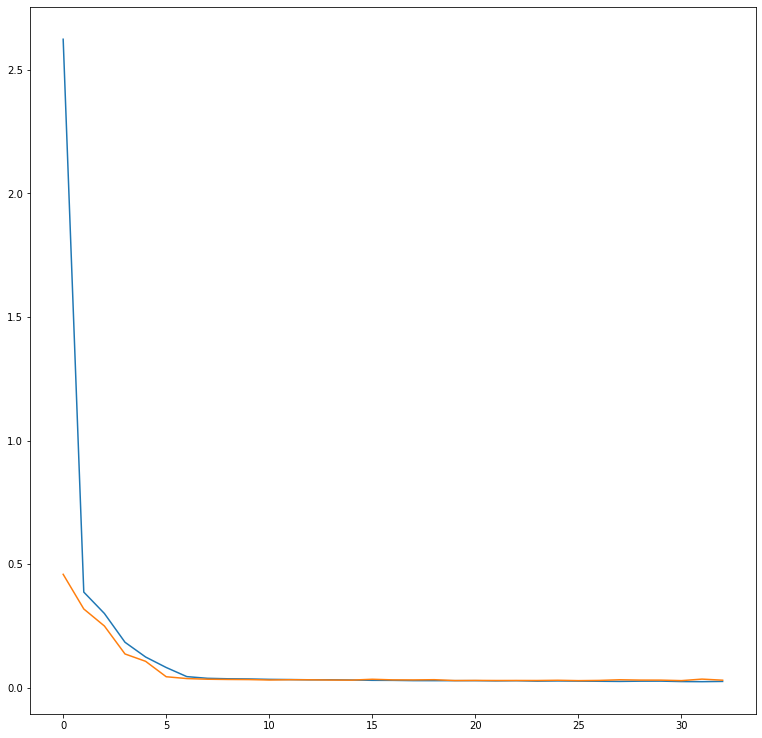

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

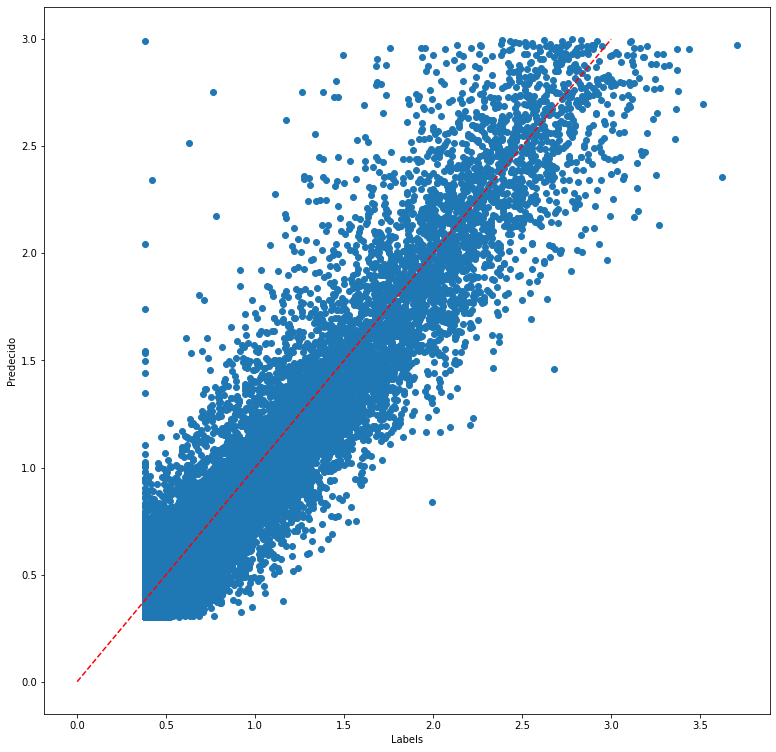

In [ ]:
#con este modelo vemos como de bien predice
plt.figure(figsize=(13,13))

predict=model.predict(x_test)
plt.scatter(predict,y_test)
plt.ylabel("Predecido")
plt.xlabel("Labels")
plt.plot([0,3],[0,3],"r--")

In [ ]:
#de este resultado podemos sacar informacion, como, que tal se ajusta a una dependencia lineal
np.corrcoef(predict[:,0],y_test)

array([[1.       , 0.9499411],
       [0.9499411, 1.       ]])

In [ ]:
!top

In [ ]:
del dat1,x_train,y_train

In [ ]:
#CONOCER LAS VARIABLES DEFINIDAS Y SUS PESOS
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

In [ ]:
#calculamos el error cuadratico medio
((predict[:,0]-y_test)**2).mean()

19839.1119525676

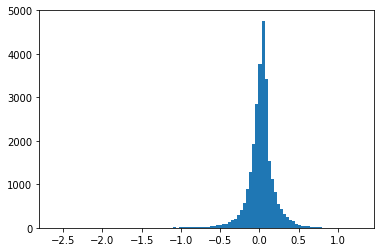

In [ ]:
#veamos como se distribuyen las diferencias
difs=(predict[:,0]-y_test)
plt.hist(difs,100);

los datos estaban en TeV 1e12, pero los hemos multiplicado por 1e3 
asi que los datos ahora estan en 1e9


In [ ]:
#calculamos la media
print(difs.mean())
#calculamos el varianza
print(difs.var())
#y la desciacion estandar
print(difs.std())

0.02081966759404835
0.031066305888810118
0.17625636410867584


Tenemos que las diferencis entre lo predicho y lo real es viene dado por una gausiana sesgada con media (-44) y con desviacion estandar de 133 
e9 eV. Si sabemos que esta sesgado podemos ccorregirlo y si sabemos como se distribuye el error podemos dar un intervalo de confianza de dicha diferencia entre valor real y predicho,

In [ ]:
# que les pasa a aquellos qeu se desvian tanto de lo que debía ser, que ve la red en ellos para fallar tanto
#vamos a obtener los indices de los mayores y menores valores de difs y vamos a ver sus correspondientes imágenes
n=3
maximos=heapq.nlargest(n*n, enumerate(np.abs(difs)), key=lambda x: x[1])
indices=[i[0] for i in maximos]
indices

[20361, 425, 6396, 14615, 5995, 9101, 1640, 7513, 11033]

In [ ]:
round(predict[indices[1]][0],2)

0.77

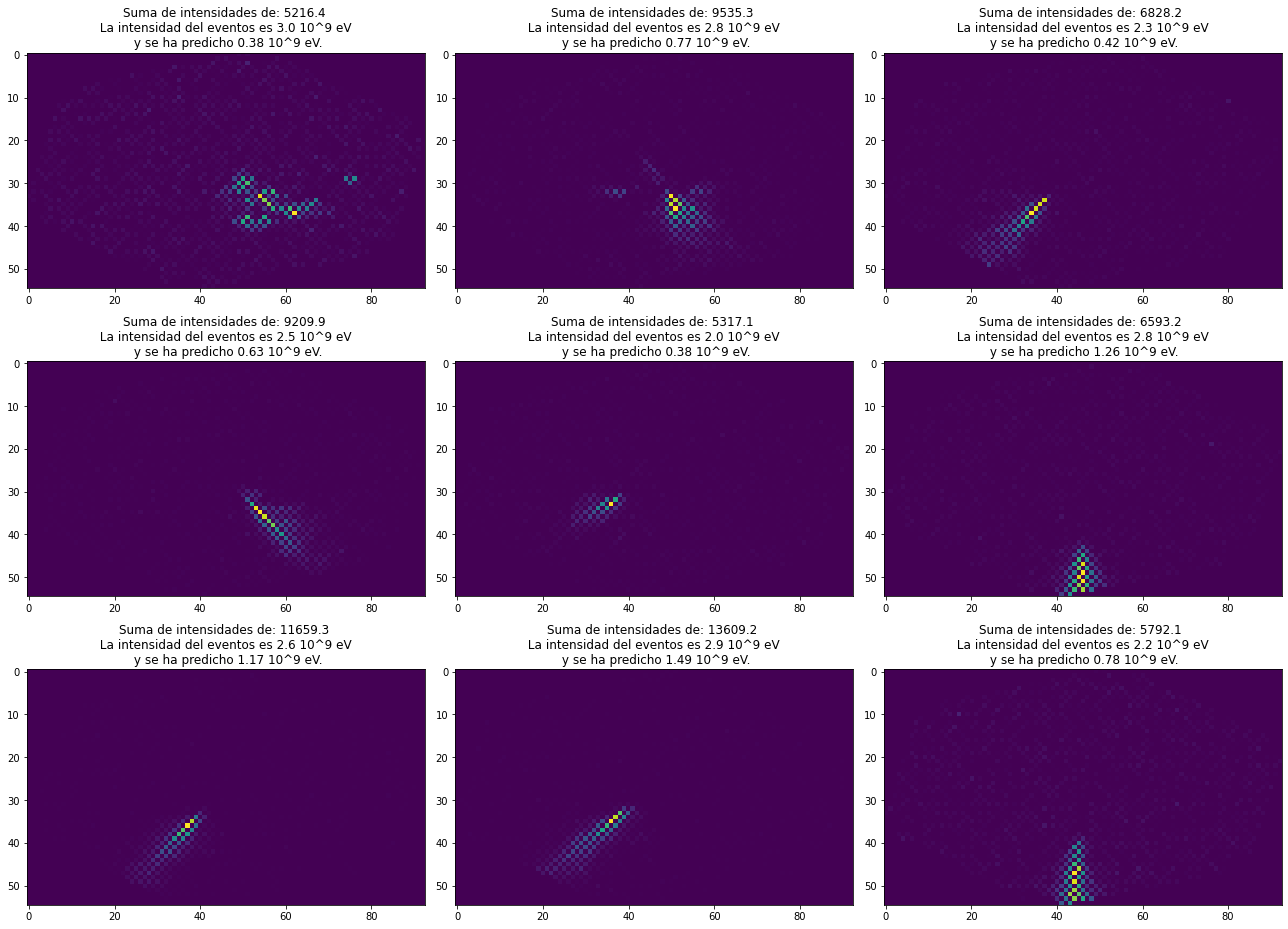

In [ ]:
plt.figure(figsize=(18,13))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(x_test[indices[i]][:,:,0])
    text=f"Suma de intensidades de: {np.sum(x_test[indices[i]][:,:,0]):.1f} \n La intensidad del eventos es {y_test[indices[i]]:.1f} 10^9 eV \n y se ha predicho {predict[indices[i]][0]:.2f} 10^9 eV."
    plt.title(text)
plt.tight_layout()

[(425, -1659.2433349609373),
 (5995, -1337.884521484375),
 (18559, -1237.4428466796876),
 (20361, -1046.102783203125),
 (14615, -1021.1418212890626),
 (11669, -925.29365234375),
 (4297, -907.138671875),
 (17296, -886.0173583984374),
 (18059, -864.6554077148437)]

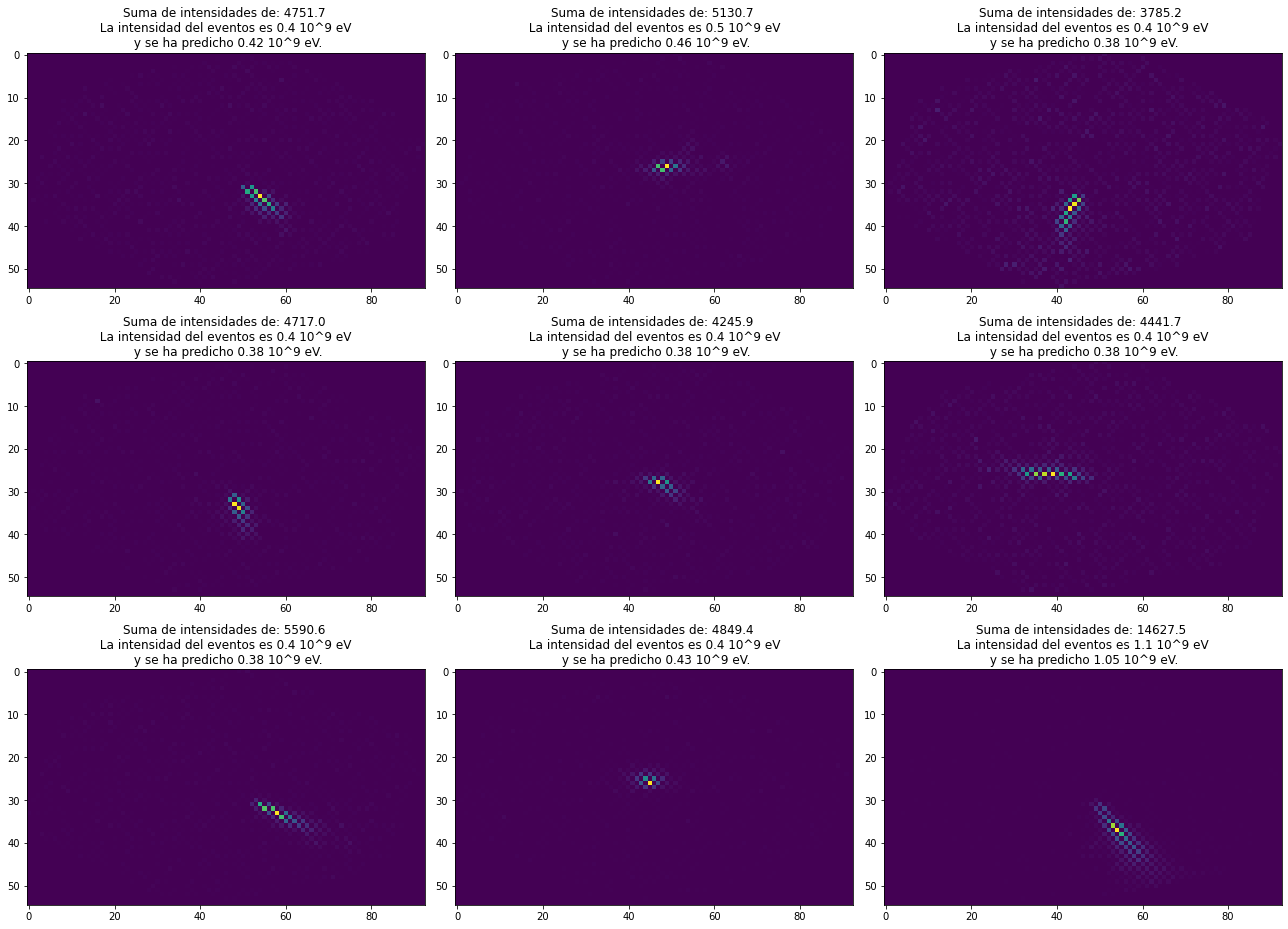

In [ ]:
#estos se han predicho muy bien
n=3
minimo=heapq.nsmallest(n*n, enumerate(abs(difs)), key=lambda x: x[1])
indices=[i[0] for i in minimo]
indices
plt.figure(figsize=(18,13))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(x_test[indices[i]][:,:,0])
    text=f"Suma de intensidades de: {np.sum(x_test[indices[i]][:,:,0]):.1f} \n La intensidad del eventos es {y_test[indices[i]]:.1f} 10^9 eV \n y se ha predicho {predict[indices[i]][0]:.2f} 10^9 eV."
    plt.title(text)

plt.tight_layout()

yo creo que la simplificacion en mi modelo no ayuda nada, el maxpooling nos quita mucha info

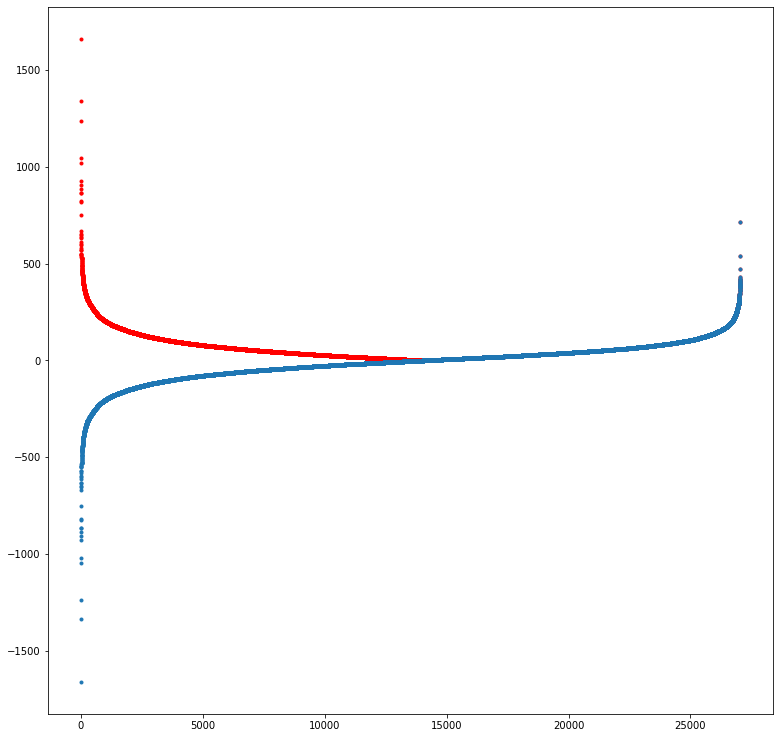

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(np.abs(sorted(difs)),"r.")
plt.plot(sorted(difs),".")

In [ ]:
#vamos a ver el error relativo de los resultados
err_rel=[100*abs(j)/y_test[i] for i ,j in enumerate(difs)]

Text(0, 0.5, 'Densidad de medidas con ese error relativo o menor \n (suman 1 el total)')

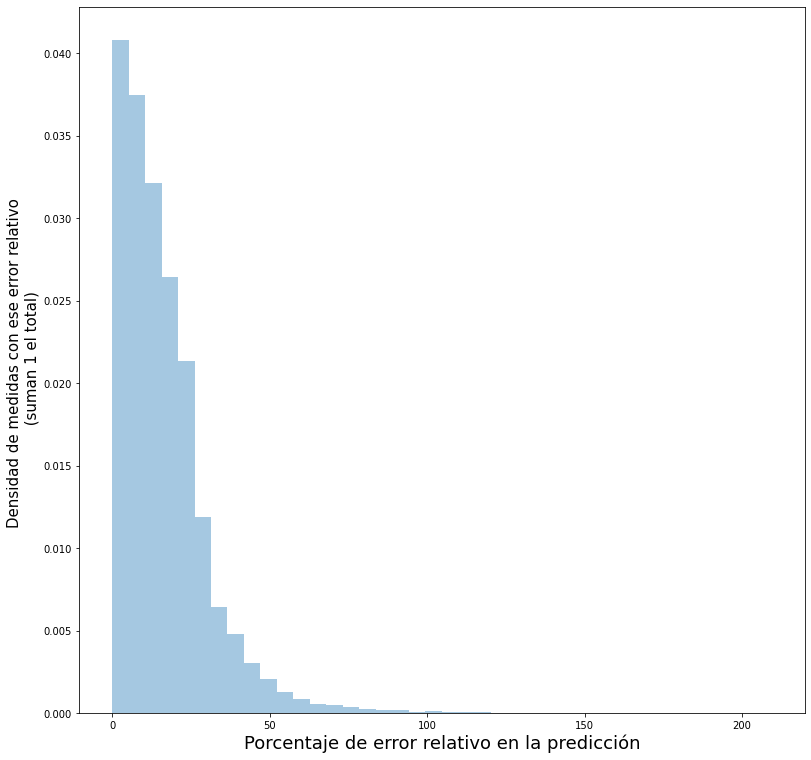

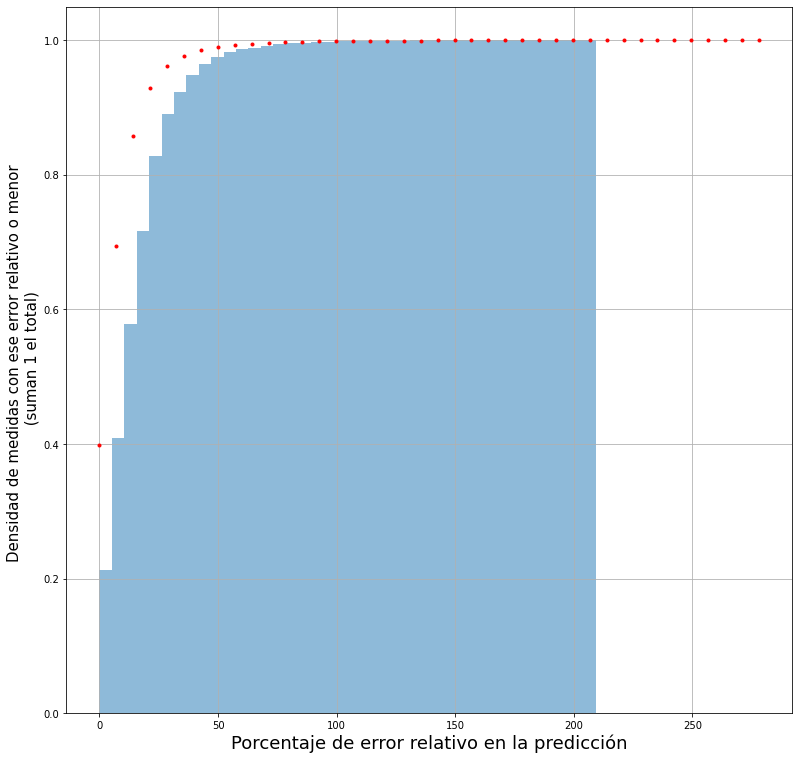

In [ ]:
plt.figure(figsize=(13,13))
plt.hist(err_rel,40,density=True,linestyle="solid",histtype="stepfilled",alpha=0.4);
plt.xlabel("Porcentaje de error relativo en la predicción",fontsize=18)
plt.ylabel("Densidad de medidas con ese error relativo \n (suman 1 el total)",fontsize=15)
plt.figure(figsize=(13,13))
datos_hist=plt.hist(err_rel,40,density=True,cumulative=True,linestyle="solid",histtype="stepfilled",alpha=0.5);
plt.plot(a[1][:-1],a[0],".r")
plt.grid()
plt.xlabel("Porcentaje de error relativo en la predicción",fontsize=18)
plt.ylabel("Densidad de medidas con ese error relativo o menor \n (suman 1 el total)",fontsize=15)

In [ ]:
datos_hist

(array([0.21347484, 0.40953297, 0.57770957, 0.71597086, 0.82782975,
        0.89021188, 0.92378804, 0.94878527, 0.96461191, 0.97533558,
        0.98195466, 0.98642902, 0.98923936, 0.99197574, 0.99397256,
        0.99522982, 0.99633916, 0.99737455, 0.99774433, 0.99837296,
        0.99863181, 0.99903857, 0.99940835, 0.99955626, 0.99959324,
        0.99974115, 0.99977813, 0.99981511, 0.99985209, 0.99988907,
        0.99988907, 0.99988907, 0.99988907, 0.99988907, 0.99996302,
        0.99996302, 0.99996302, 0.99996302, 0.99996302, 1.        ]),
 array([3.44605581e-04, 5.23455498e+00, 1.04687654e+01, 1.57029757e+01,
        2.09371861e+01, 2.61713965e+01, 3.14056069e+01, 3.66398172e+01,
        4.18740276e+01, 4.71082380e+01, 5.23424483e+01, 5.75766587e+01,
        6.28108691e+01, 6.80450795e+01, 7.32792898e+01, 7.85135002e+01,
        8.37477106e+01, 8.89819210e+01, 9.42161313e+01, 9.94503417e+01,
        1.04684552e+02, 1.09918762e+02, 1.15152973e+02, 1.20387183e+02,
        1.25621394e+02

In [ ]:
#modelo 1.2
a=np.array([np.array([0.39895722, 0.69467145, 0.85707947, 0.92881707, 0.96165366,
        0.97736937, 0.98587435, 0.99042266, 0.99297415, 0.99508191,
        0.99659801, 0.99741153, 0.99785527, 0.99829901, 0.99866879,
        0.99900159, 0.99911252, 0.99922346, 0.99944533, 0.99963022,
        0.9996672 , 0.99970417, 0.99974115, 0.99977813, 0.99981511,
        0.99985209, 0.99985209, 0.99985209, 0.99985209, 0.99988907,
        0.99988907, 0.99988907, 0.99988907, 0.99988907, 0.99988907,
        0.99988907, 0.99992604, 0.99992604, 0.99992604, 1.        ]),
 np.array([3.11809301e-04, 7.12915840e+00, 1.42580050e+01, 2.13868516e+01,
        2.85156982e+01, 3.56445448e+01, 4.27733914e+01, 4.99022380e+01,
        5.70310845e+01, 6.41599311e+01, 7.12887777e+01, 7.84176243e+01,
        8.55464709e+01, 9.26753175e+01, 9.98041641e+01, 1.06933011e+02,
        1.14061857e+02, 1.21190704e+02, 1.28319550e+02, 1.35448397e+02,
        1.42577244e+02, 1.49706090e+02, 1.56834937e+02, 1.63963783e+02,
        1.71092630e+02, 1.78221477e+02, 1.85350323e+02, 1.92479170e+02,
        1.99608016e+02, 2.06736863e+02, 2.13865710e+02, 2.20994556e+02,
        2.28123403e+02, 2.35252249e+02, 2.42381096e+02, 2.49509943e+02,
        2.56638789e+02, 2.63767636e+02, 2.70896482e+02, 2.78025329e+02,
        2.85154175e+02])])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


EL MODELO 1.2 CON MAS COMPLEJIDAD ES NOTABLEMENTE MEJOR

## Entrenamiento 2, caracteristicas...

No vamos a hacer nada que reduzca las dimensines simplificando, el maxpooling o ayuda



In [ ]:
#cargamos los datos

datos=sorted(glob.glob(f"{npy_sin_norm}/aux_npy*tel_*_run_*.npy"))
labels=sorted(glob.glob(f"{npy_sin_norm}/event*tel_*_run_*.npy"))
dat1=np.load(datos[0])
lab=np.load(labels[0])[:,1]
suma_intensidades=[[np.sum(i) for i in dat1]]
if dat1.shape[0]!= lab.shape[0]:
    print("LAS DIMENSIONES ESTÁN MAL, LA PRIMERA QUE COJAS DEBE ESTAR BIEN")
print("0",dat1.shape,lab.shape)
for i in range(1,len(datos)):
    aux_dat=np.load(datos[i])
    aux_lab=np.load(labels[i])[:,1]
    if aux_dat.shape[0]== aux_lab.shape[0]:
        suma_intensidades.append([np.sum(j) for j in aux_dat])
        dat1=np.concatenate((dat1,aux_dat))
        lab=np.concatenate((lab,aux_lab))
        print(len(suma_intensidades),dat1.shape,lab.shape)
    else:
        pass
    del aux_dat, aux_lab
suma_intensidades=np.concatenate(suma_intensidades)
dat=dat1[...,np.newaxis]
del dat1

0 (1999, 55, 93) (1999,)
2 (3998, 55, 93) (3998,)
3 (5997, 55, 93) (5997,)
4 (7995, 55, 93) (7995,)
5 (9994, 55, 93) (9994,)
6 (11993, 55, 93) (11993,)
7 (13992, 55, 93) (13992,)
8 (15991, 55, 93) (15991,)
9 (17989, 55, 93) (17989,)
10 (19988, 55, 93) (19988,)
11 (21987, 55, 93) (21987,)
12 (23986, 55, 93) (23986,)
13 (25985, 55, 93) (25985,)
14 (27983, 55, 93) (27983,)
15 (29982, 55, 93) (29982,)
16 (31981, 55, 93) (31981,)
17 (33978, 55, 93) (33978,)
18 (35977, 55, 93) (35977,)
19 (37976, 55, 93) (37976,)
20 (39975, 55, 93) (39975,)
21 (41973, 55, 93) (41973,)
22 (43972, 55, 93) (43972,)
23 (45971, 55, 93) (45971,)
24 (47970, 55, 93) (47970,)
25 (49969, 55, 93) (49969,)
26 (51968, 55, 93) (51968,)
27 (53966, 55, 93) (53966,)
28 (55965, 55, 93) (55965,)
29 (57964, 55, 93) (57964,)
30 (59963, 55, 93) (59963,)
31 (61962, 55, 93) (61962,)
32 (63960, 55, 93) (63960,)
33 (65958, 55, 93) (65958,)
34 (67956, 55, 93) (67956,)
35 (69955, 55, 93) (69955,)
36 (71954, 55, 93) (71954,)
37 (73953, 

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(dat,lab,test_size=0.33,random_state=42)
del dat, lab

In [ ]:
#definimos el modelo
#creación de modelo
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64,kernel_size=3,padding="same", input_shape=(55,93,1),activation="relu"))
model.add(tf.keras.layers.Conv2D(32,kernel_size=3,padding="same",activation="relu"))
model.add(tf.keras.layers.AveragePooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(32,kernel_size=3,padding="same", input_shape=(55,93,1),activation="relu"))
model.add(tf.keras.layers.Conv2D(16,kernel_size=3,padding="same",activation="relu"))
model.add(tf.keras.layers.AveragePooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(16,kernel_size=3,activation="relu"))
model.add(tf.keras.layers.AveragePooling2D((2,2)))
model.add(tf.keras.layers.Dropout(0.35))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100,activation="relu"))
model.add(tf.keras.layers.Dense(20,activation="relu"))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 93, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 93, 32)        18464     
_________________________________________________________________
average_pooling2d (AveragePo (None, 27, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 46, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 46, 16)        4624      
_________________________________________________________________
average_pooling2d_1 (Average (None, 13, 23, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 21, 16)        2

In [ ]:
#del x_train,x_test,y_test,y_train

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(patience=7)
model.compile(optimizer="adam",loss="mse")

In [ ]:
history=model.fit(x_train,y_train,epochs=100,batch_size=64,validation_data=(x_test,y_test),callbacks=[stop])

Epoch 1/100
858/858 [==============================] - 81s 60ms/step - loss: 0.1108 - val_loss: 0.0359
Epoch 2/100
858/858 [==============================] - 50s 58ms/step - loss: 0.0461 - val_loss: 0.0311
Epoch 3/100
858/858 [==============================] - 49s 58ms/step - loss: 0.0390 - val_loss: 0.0436
Epoch 4/100
858/858 [==============================] - 50s 58ms/step - loss: 0.0369 - val_loss: 0.0247
Epoch 5/100
858/858 [==============================] - 50s 58ms/step - loss: 0.0317 - val_loss: 0.0261
Epoch 6/100
858/858 [==============================] - 50s 58ms/step - loss: 0.0316 - val_loss: 0.0283
Epoch 7/100
858/858 [==============================] - 50s 58ms/step - loss: 0.0297 - val_loss: 0.0270
Epoch 8/100
858/858 [==============================] - 49s 57ms/step - loss: 0.0288 - val_loss: 0.0252
Epoch 9/100
858/858 [==============================] - 49s 57ms/step - loss: 0.0273 - val_loss: 0.0249
Epoch 10/100
858/858 [==============================] - 49s 57ms/step - l

In [ ]:
#model.save(f"{base_dir}/model_predict_energy_2.h5")

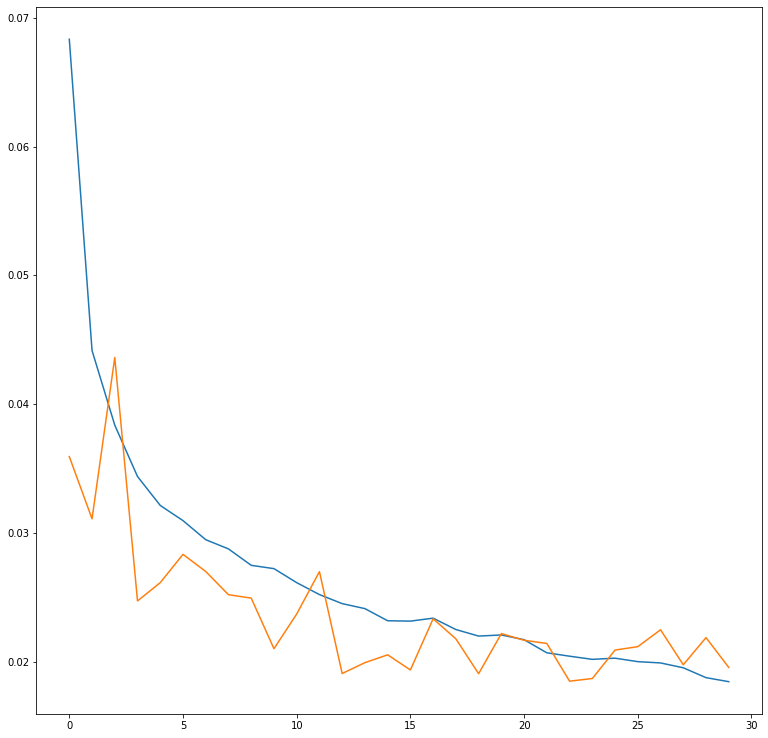

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

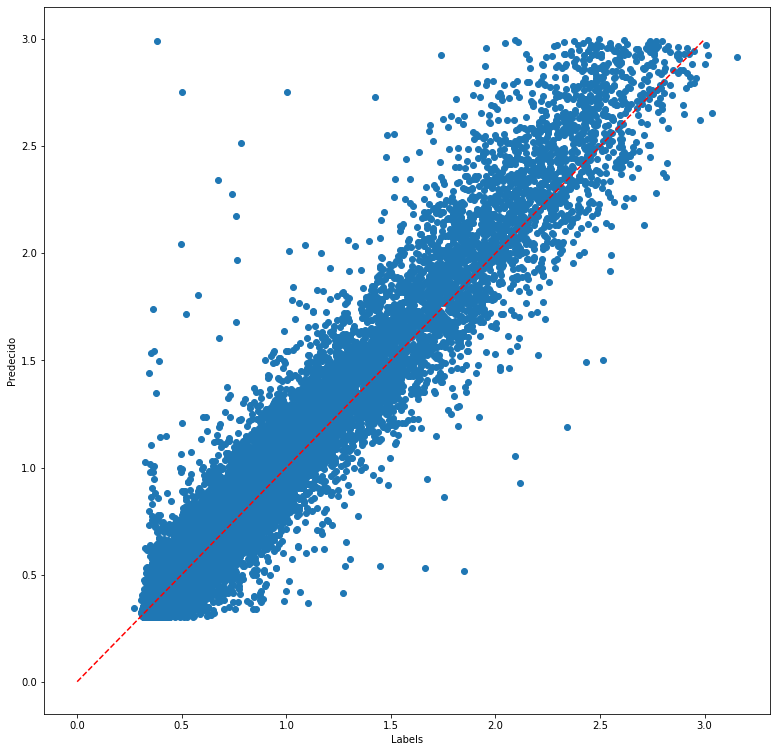

In [ ]:
#con este modelo vemos como de bien predice
plt.figure(figsize=(13,13))

predict=model.predict(x_test)
plt.scatter(predict,y_test)
plt.ylabel("Predecido")
plt.xlabel("Labels")
plt.plot([0,3],[0,3],"r--")

In [ ]:
#de este resultado podemos sacar informacion, como, que tal se ajusta a una dependencia lineal
np.corrcoef(predict[:,0],y_test)

array([[1.        , 0.97071991],
       [0.97071991, 1.        ]])

In [ ]:
#calculamos el error cuadratico medio
((predict[:,0]-y_test)**2).mean()

21579.74344353261

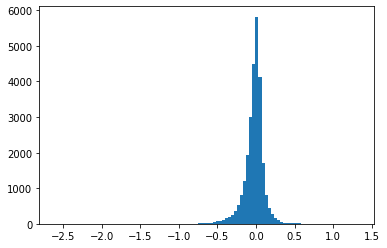

In [ ]:
#veamos como se distribuyen las diferencias
difs=(predict[:,0]-y_test)
plt.hist(difs,100);

In [ ]:
#calculamos la media
print(difs.mean())
#calculamos el varianza
print(difs.var())
#y la desciacion estandar
print(difs.std())

-0.027036713098315044
0.01881700885681357
0.13717510290433016


In [ ]:
# que les pasa a aquellos qeu se desvian tanto de lo que debía ser, que ve la red en ellos para fallar tanto
#vamos a obtener los indices de los mayores y menores valores de difs y vamos a ver sus correspondientes imágenes
n=3
maximos=heapq.nlargest(n**2, enumerate(difs), key=lambda x: x[1])
indices=[i[0] for i in maximos]
maximos

[(25082, 1.3324588167190552),
 (164, 1.1920391582489014),
 (10226, 1.1498752544403077),
 (16407, 1.1296071432113648),
 (23120, 1.039541495513916),
 (17747, 1.015417129135132),
 (22646, 0.9410561222076417),
 (21904, 0.9106907720565796),
 (18218, 0.8931455694198608)]

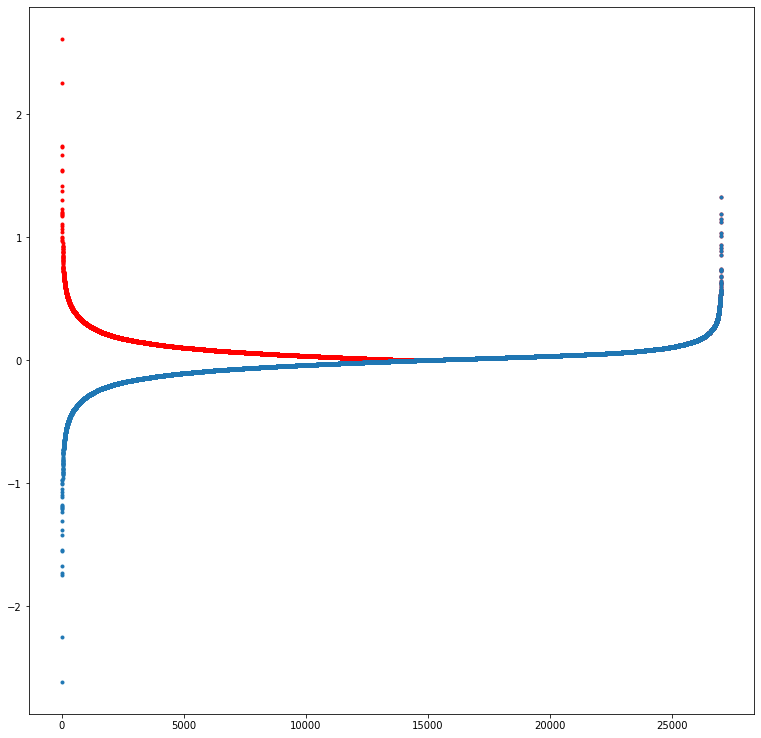

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(np.abs(sorted(difs)),"r.")
plt.plot(sorted(difs),".")

In [ ]:
#vamos a ver el error relativo de los resultados
err_rel=[100*abs(j)/y_test[i] for i ,j in enumerate(difs)]

Text(0, 0.5, 'Densidad de medidas con ese error relativo o menor \n (suman 1 el total)')

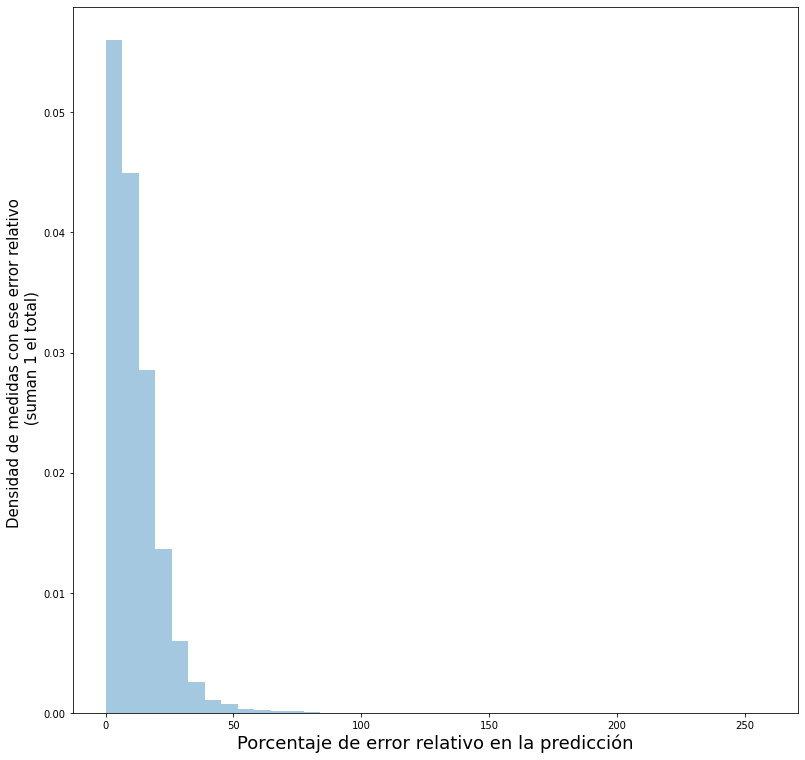

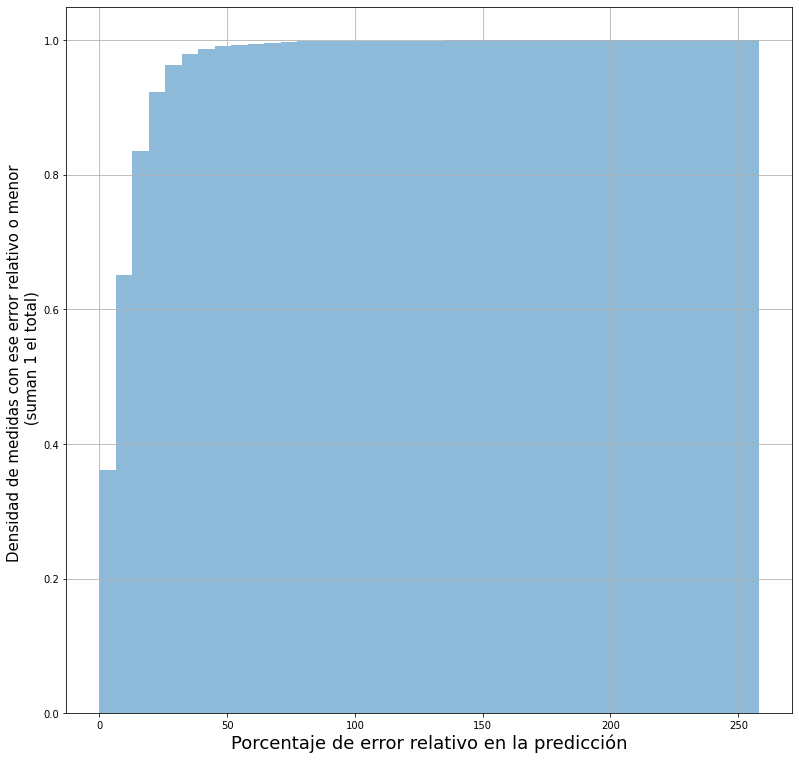

In [ ]:
plt.figure(figsize=(13,13))
plt.hist(err_rel,40,density=True,linestyle="solid",histtype="stepfilled",alpha=0.4);
plt.xlabel("Porcentaje de error relativo en la predicción",fontsize=18)
plt.ylabel("Densidad de medidas con ese error relativo \n (suman 1 el total)",fontsize=15)
plt.figure(figsize=(13,13))
datos_hist=plt.hist(err_rel,40,density=True,cumulative=True,linestyle="solid",histtype="stepfilled",alpha=0.5);
plt.grid()
plt.xlabel("Porcentaje de error relativo en la predicción",fontsize=18)
plt.ylabel("Densidad de medidas con ese error relativo o menor \n (suman 1 el total)",fontsize=15)

In [ ]:
datos_hist

(array([0.36112857, 0.65129608, 0.8357061 , 0.92371408, 0.96276301,
        0.97929224, 0.98642902, 0.9911992 , 0.99352882, 0.99504493,
        0.99637614, 0.99741153, 0.99826203, 0.9984839 , 0.99863181,
        0.99885368, 0.99911252, 0.99929742, 0.99937137, 0.99948231,
        0.99963022, 0.9996672 , 0.9996672 , 0.99977813, 0.99977813,
        0.99981511, 0.99985209, 0.99985209, 0.99985209, 0.99985209,
        0.99988907, 0.99992604, 0.99996302, 0.99996302, 0.99996302,
        0.99996302, 0.99996302, 0.99996302, 0.99996302, 1.        ]),
 array([2.56819538e-03, 6.45446417e+00, 1.29063601e+01, 1.93582561e+01,
        2.58101521e+01, 3.22620481e+01, 3.87139441e+01, 4.51658400e+01,
        5.16177360e+01, 5.80696320e+01, 6.45215280e+01, 7.09734239e+01,
        7.74253199e+01, 8.38772159e+01, 9.03291119e+01, 9.67810078e+01,
        1.03232904e+02, 1.09684800e+02, 1.16136696e+02, 1.22588592e+02,
        1.29040488e+02, 1.35492384e+02, 1.41944280e+02, 1.48396176e+02,
        1.54848072e+02

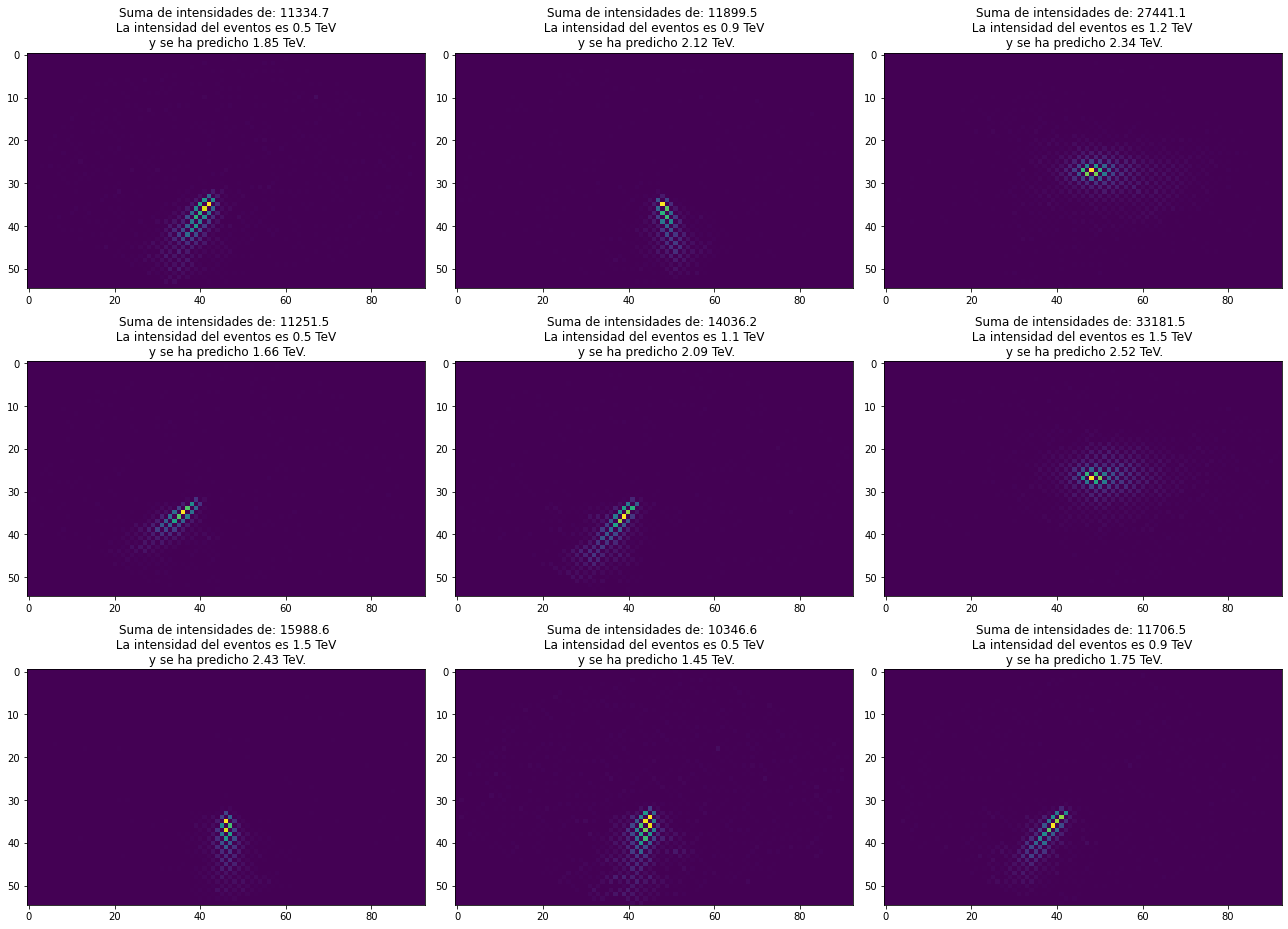

In [ ]:
plt.figure(figsize=(18,13))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(x_test[indices[i]][:,:,0])
    text=f"Suma de intensidades de: {np.sum(x_test[indices[i]][:,:,0]):.1f} \n La intensidad del eventos es {y_test[indices[i]]:.1f} TeV \n y se ha predicho {predict[indices[i]][0]:.2f} TeV."
    plt.title(text)
plt.tight_layout()

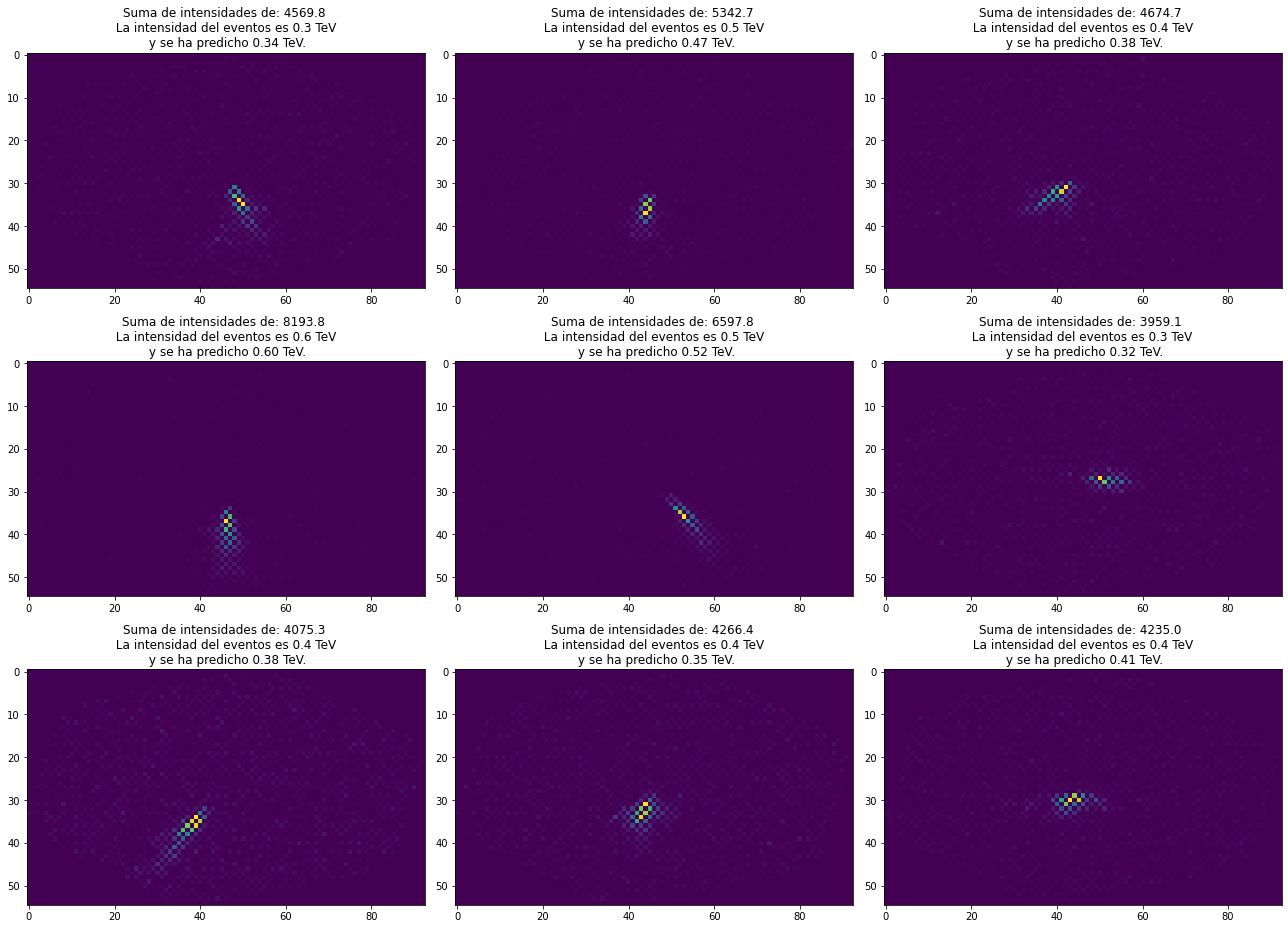

In [ ]:
#estos se han predicho muy bien
n=3
minimo=heapq.nsmallest(n*n, enumerate(abs(difs)), key=lambda x: x[1])
indices=[i[0] for i in minimo]
indices
plt.figure(figsize=(18,13))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(x_test[indices[i]][:,:,0])
    text=f"Suma de intensidades de: {np.sum(x_test[indices[i]][:,:,0]):.1f} \n La intensidad del eventos es {y_test[indices[i]]:.1f} TeV \n y se ha predicho {predict[indices[i]][0]:.2f} TeV."
    plt.title(text)

plt.tight_layout()

## Entrenamiento 3, ...

Vamos a aplicar transfer learning para una primera parte, y luego vamos a meterle unas dense layers

In [ ]:
#tenemos un problemilla y es que nuestra red acepta solo imágenes con tres canales, nuestra imagen tiene un solo canal,
#tenemos que hacer algo al respecto, asi que vamos a copiar la misma imagen 3 veces porque sino..

#cargamos los datos CON TRES CANALES
num_archivos_cargados=17 #al tener tres canales esto pesa muchisimo podemos tener problemas de memoria
#num_archivos_cargados=len(datos) #esto si no tenemos problemas de memoria

datos=sorted(glob.glob(f"{npy_sin_norm}/aux_npy*tel_*_run_*.npy"))
labels=sorted(glob.glob(f"{npy_sin_norm}/event*tel_*_run_*.npy"))

dat1=np.load(datos[0])
dat1=np.stack((dat1,)*3,axis=-1)
lab=np.load(labels[0])[:,1]
if dat1.shape[0]!= lab.shape[0]:
    print("LAS DIMENSIONES ESTÁN MAL, LA PRIMERA QUE COJAS DEBE ESTAR BIEN")
for i in range(1,num_archivos_cargados):
    print(i)
    aux_dat=np.load(datos[i])
    aux_lab=np.load(labels[i])[:,1]
    aux_dat=np.stack((aux_dat,)*3,axis=-1)
    if aux_dat.shape[0]== aux_lab.shape[0]:
        dat1=np.concatenate((dat1,aux_dat))
        lab=np.concatenate((lab,aux_lab))
    else:
        pass
    del aux_dat, aux_lab


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [ ]:
half_max_value_ints=(np.amax(dat1[:,:,:,0]))/2


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(dat1,lab,test_size=0.2,random_state=42)
del dat1, lab

In [ ]:
#cargamos el modelo y todo eso 
modelo_cargado=tf.keras.applications.DenseNet169(include_top=False,input_shape=(55,93,3))

51879936/51877672 [==============================] - 2s 0us/step


In [ ]:
modelo_cargado.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55, 93, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 61, 99, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 28, 47, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 28, 47, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
#lo ponemos para que no se pueda entrenar esa parte
modelo_cargado.trainable=False

In [ ]:
#creamos el modelo añadiendo unas cuantas redes densas al final
#es importante darle al modelo un imput que le resulte familiar y tal, por ello tenemos que normalizar el input
# lo normal parece ser que vaya de [0,255] a [-1,+1]
#nuestros datos son intensidades entonces lo que vamos a hacer es buscar el máximo valor

#esto lo estoy copiando talcual de la documentacion
inputs = tf.keras.Input(shape=(55, 93, 3))
# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
mean = np.array([half_max_value_ints] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(inputs)
norm_layer.set_weights([mean, var])
x = modelo_cargado(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)  # Regularize with dropout
x = tf.keras.layers.Dense(100,activation="relu")(x)
outputs=tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 55, 93, 3)]       0         
_________________________________________________________________
normalization (Normalization (None, 55, 93, 3)         7         
_________________________________________________________________
densenet169 (Functional)     (None, 1, 3, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               166500    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101   

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(patience=6)
model.compile(optimizer="adam",loss="mse")

In [ ]:
history=model.fit(x_train,y_train,epochs=100,batch_size=64,validation_data=(x_test,y_test),callbacks=[stop])

Epoch 1/100
425/425 [==============================] - 93s 125ms/step - loss: 0.2552 - val_loss: 0.1268
Epoch 2/100
425/425 [==============================] - 46s 108ms/step - loss: 0.0949 - val_loss: 0.0587
Epoch 3/100
425/425 [==============================] - 46s 107ms/step - loss: 0.0815 - val_loss: 0.0600
Epoch 4/100
425/425 [==============================] - 46s 107ms/step - loss: 0.0813 - val_loss: 0.0559
Epoch 5/100
425/425 [==============================] - 45s 107ms/step - loss: 0.0761 - val_loss: 0.0698
Epoch 6/100
425/425 [==============================] - 45s 107ms/step - loss: 0.0760 - val_loss: 0.0535
Epoch 7/100
425/425 [==============================] - 45s 107ms/step - loss: 0.0725 - val_loss: 0.0547
Epoch 8/100
425/425 [==============================] - 45s 107ms/step - loss: 0.0707 - val_loss: 0.0579
Epoch 9/100
425/425 [==============================] - 46s 109ms/step - loss: 0.0685 - val_loss: 0.0919
Epoch 10/100
425/425 [==============================] - 46s 109m

ha llegado hasta epoch 17 con mae

con mse hasta el 27


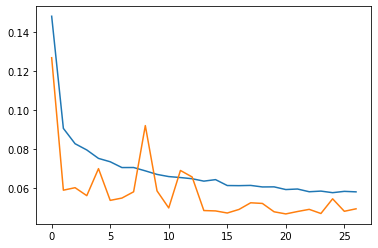

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [ ]:
#CONOCER LAS VARIABLES DEFINIDAS Y SUS PESOS
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

In [ ]:
#ahora hacemos el finetuning
modelo_cargado.trainable=True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss="mse")

In [ ]:
#vamos a cargar el resto de datos para entrenar la red poco a poco y sin necesitar cargar todos los datos de golpe

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(patience=5)
history=model.fit(x_train,y_train,epochs=100,batch_size=64,validation_data=(x_test,y_test),callbacks=[stop])

Epoch 1/100
425/425 [==============================] - 168s 351ms/step - loss: 0.1156 - val_loss: 0.0430
Epoch 2/100
425/425 [==============================] - 143s 337ms/step - loss: 0.0468 - val_loss: 0.0349
Epoch 3/100
425/425 [==============================] - 143s 337ms/step - loss: 0.0393 - val_loss: 0.0335
Epoch 4/100
425/425 [==============================] - 143s 337ms/step - loss: 0.0357 - val_loss: 0.0325
Epoch 5/100
425/425 [==============================] - 143s 336ms/step - loss: 0.0329 - val_loss: 0.0298
Epoch 6/100
425/425 [==============================] - 143s 337ms/step - loss: 0.0308 - val_loss: 0.0285
Epoch 7/100
425/425 [==============================] - 143s 337ms/step - loss: 0.0301 - val_loss: 0.0268
Epoch 8/100
425/425 [==============================] - 143s 336ms/step - loss: 0.0289 - val_loss: 0.0330
Epoch 9/100
425/425 [==============================] - 142s 334ms/step - loss: 0.0271 - val_loss: 0.0282
Epoch 10/100
425/425 [==============================] -

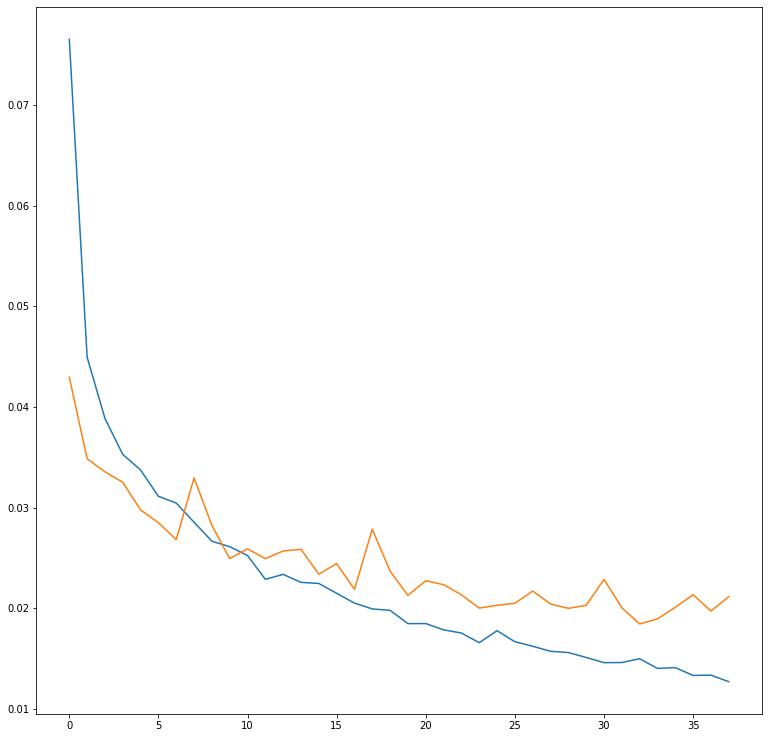

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

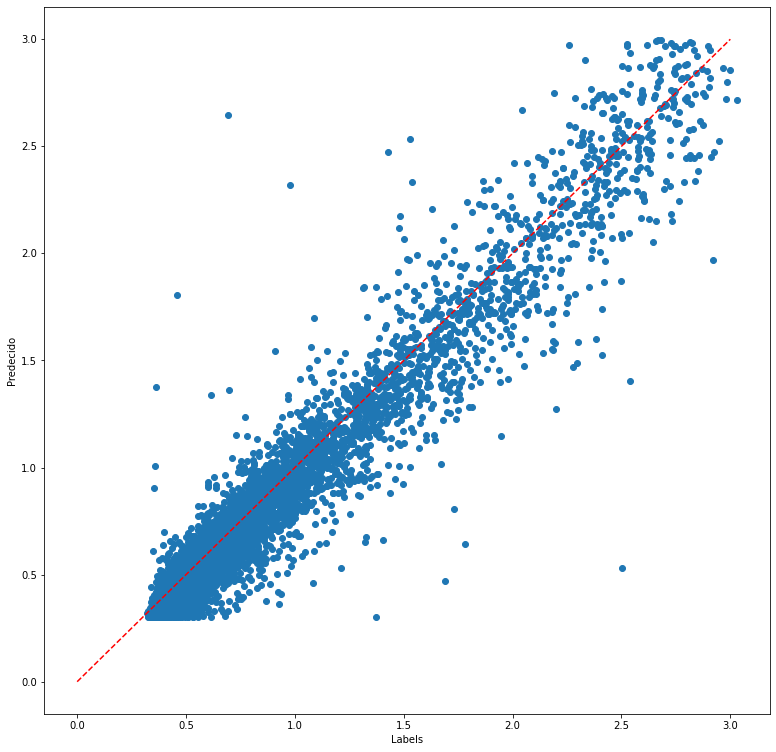

In [ ]:
#con este modelo vemos como de bien predice
plt.figure(figsize=(13,13))

predict=model.predict(x_test)
plt.scatter(predict,y_test)
plt.ylabel("Predecido")
plt.xlabel("Labels")
plt.plot([0,3],[0,3],"r--")

In [ ]:
#de este resultado podemos sacar informacion, como, que tal se ajusta a una dependencia lineal
np.corrcoef(predict[:,0],y_test)

array([[1.        , 0.96943852],
       [0.96943852, 1.        ]])

In [ ]:
predict

array([[0.47479945],
       [1.0056019 ],
       [0.4896744 ],
       ...,
       [0.37019825],
       [0.4028704 ],
       [0.60527277]], dtype=float32)

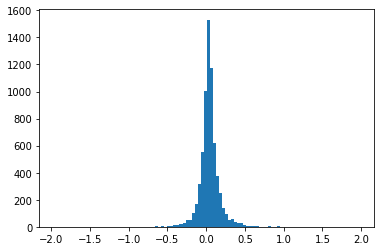

In [ ]:
#veamos como se distribuyen las diferencias
difs=(predict[:,0]-y_test)
plt.hist(difs,100);

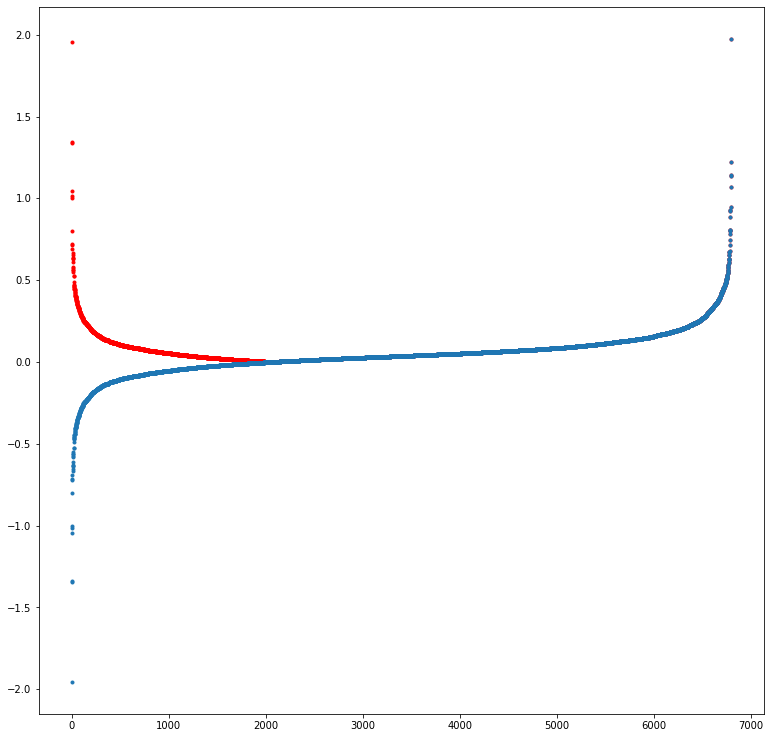

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(np.abs(sorted(difs)),"r.")
plt.plot(sorted(difs),".")

In [ ]:
#vamos a ver el error relativo de los resultados
err_rel=[100*abs(j)/y_test[i] for i ,j in enumerate(difs)]

Text(0, 0.5, 'Densidad de medidas con ese error relativo o menor \n (suman 1 el total)')

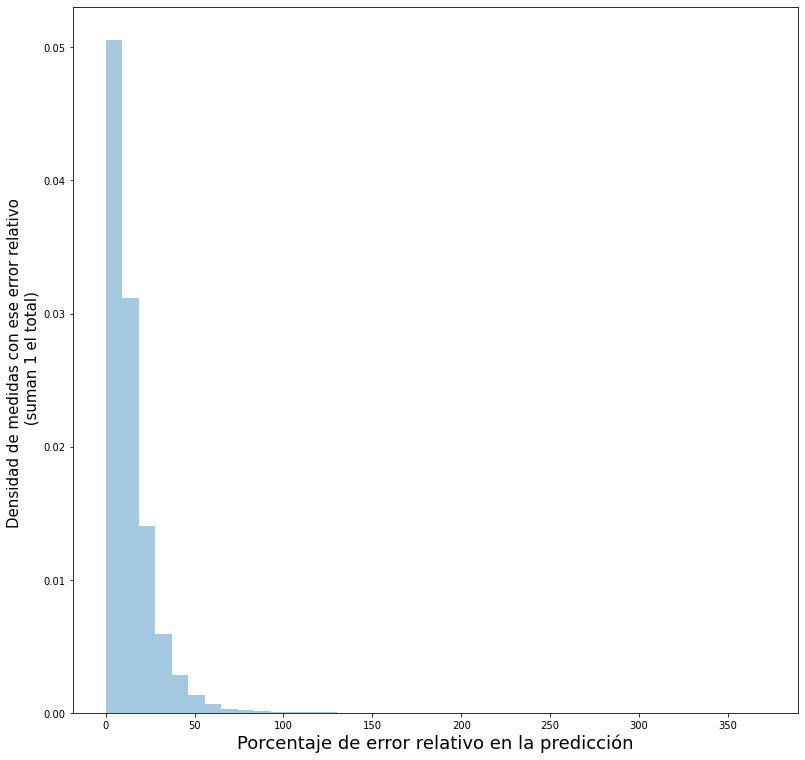

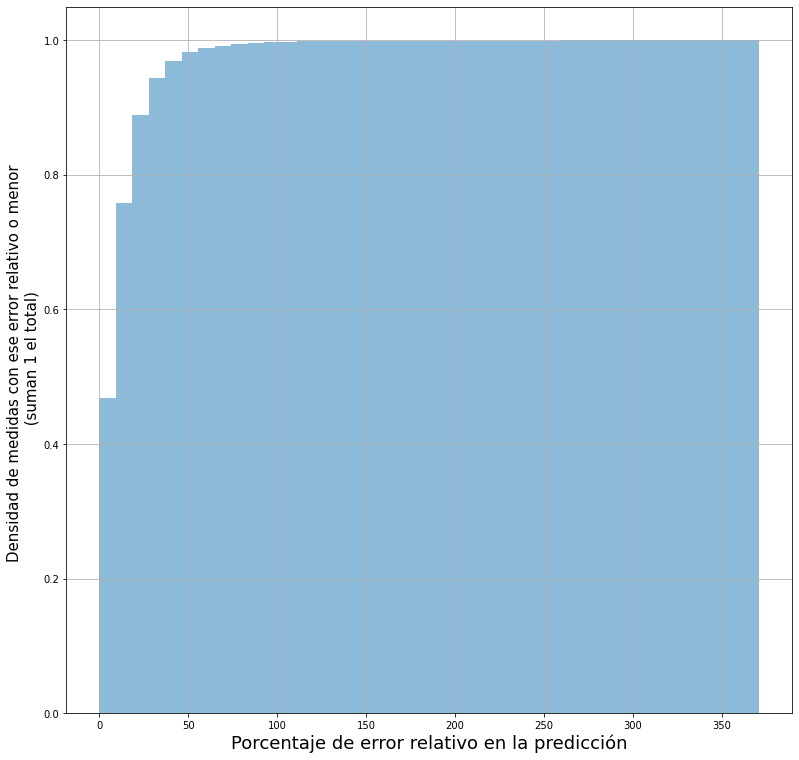

In [ ]:
plt.figure(figsize=(13,13))
plt.hist(err_rel,40,density=True,linestyle="solid",histtype="stepfilled",alpha=0.4);
plt.xlabel("Porcentaje de error relativo en la predicción",fontsize=18)
plt.ylabel("Densidad de medidas con ese error relativo \n (suman 1 el total)",fontsize=15)
plt.figure(figsize=(13,13))
datos_hist=plt.hist(err_rel,40,density=True,cumulative=True,linestyle="solid",histtype="stepfilled",alpha=0.5);
plt.grid()
plt.xlabel("Porcentaje de error relativo en la predicción",fontsize=18)
plt.ylabel("Densidad de medidas con ese error relativo o menor \n (suman 1 el total)",fontsize=15)

In [ ]:
datos_hist

(array([0.46851089, 0.75779871, 0.88831666, 0.94334903, 0.96968805,
        0.98234255, 0.98911124, 0.99220129, 0.99455562, 0.99632137,
        0.99720424, 0.99779282, 0.99852855, 0.99911713, 0.99926427,
        0.99926427, 0.99941142, 0.99941142, 0.99941142, 0.99955856,
        0.99955856, 0.99955856, 0.99955856, 0.99955856, 0.99955856,
        0.99955856, 0.99955856, 0.99955856, 0.99970571, 0.99970571,
        0.99970571, 0.99970571, 0.99970571, 0.99970571, 0.99970571,
        0.99970571, 0.99970571, 0.99985285, 0.99985285, 1.        ]),
 array([2.54342347e-03, 9.27632758e+00, 1.85501117e+01, 2.78238959e+01,
        3.70976800e+01, 4.63714642e+01, 5.56452483e+01, 6.49190325e+01,
        7.41928167e+01, 8.34666008e+01, 9.27403850e+01, 1.02014169e+02,
        1.11287953e+02, 1.20561737e+02, 1.29835522e+02, 1.39109306e+02,
        1.48383090e+02, 1.57656874e+02, 1.66930658e+02, 1.76204442e+02,
        1.85478227e+02, 1.94752011e+02, 2.04025795e+02, 2.13299579e+02,
        2.22573363e+02

In [ ]:
#calculamos la media
print(difs.mean())
#calculamos el varianza
print(difs.var())
#y la desciacion estandar
print(difs.std())

-0.0490886818720735
0.024166035948804034
0.15545428893666471


In [ ]:
# que les pasa a aquellos qeu se desvian tanto de lo que debía ser, que ve la red en ellos para fallar tanto
#vamos a obtener los indices de los mayores y menores valores de difs y vamos a ver sus correspondientes imágenes
n=4
maximos=heapq.nlargest(n**2, enumerate(abs(difs)), key=lambda x: x[1])
indices=[i[0] for i in maximos]
maximos

[(582, 2.0493149260520935),
 (2775, 1.6620408510208131),
 (2647, 1.4549241218090057),
 (2386, 1.3315213392257692),
 (2192, 1.2705749778747557),
 (1533, 1.06591418800354),
 (3057, 1.040290302848816),
 (1345, 0.9645105695724485),
 (64, 0.9477666730880738),
 (165, 0.9384163684844973),
 (338, 0.883679648590088),
 (353, 0.8477709056854248),
 (3041, 0.8398885929107665),
 (1513, 0.8267890258789063),
 (219, 0.8198438444137572),
 (1607, 0.81646163520813)]

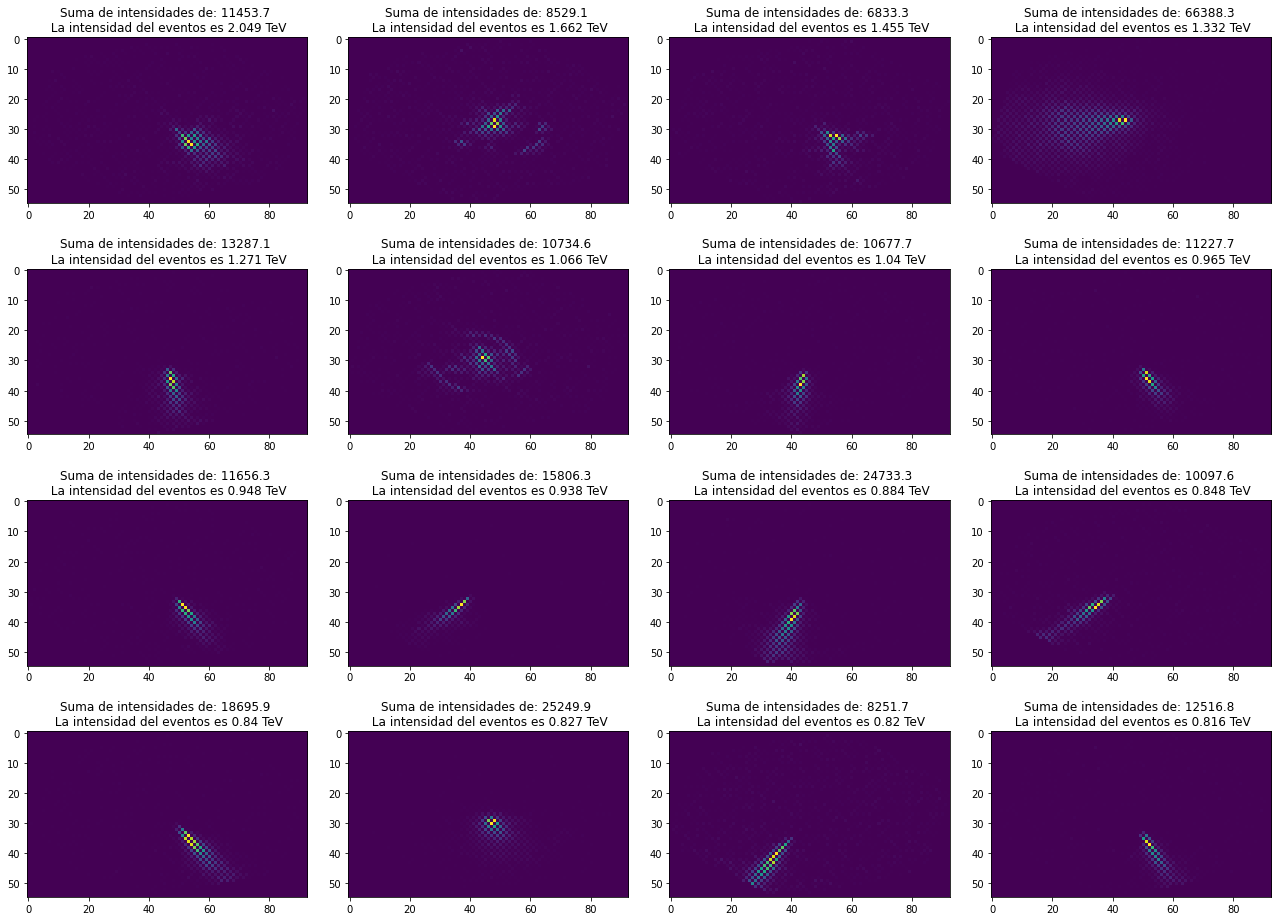

In [ ]:
plt.figure(figsize=(18,13))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(x_test[indices[i]][:,:,0])
    text=f"Suma de intensidades de: {np.sum(x_test[indices[i]][:,:,0]):.1f} \n La intensidad del eventos es {y_test[indices[i]]:.1f} TeV \n y se ha predicho {predict[indices[i]][0]:.2f} TeV."
    plt.title(text)
plt.tight_layout()

In [ ]:
#estos se han predicho muy bien
n=3
minimo=heapq.nsmallest(n*n, enumerate(abs(difs)), key=lambda x: x[1])
indices=[i[0] for i in minimo]
indices
plt.figure(figsize=(18,13))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(x_test[indices[i]][:,:,0])
    text=f"Suma de intensidades de: {np.sum(x_test[indices[i]][:,:,0]):.1f} \n La intensidad del eventos es {y_test[indices[i]]:.1f} TeV \n y se ha predicho {predict[indices[i]][0]:.2f} TeV."
    plt.title(text)

plt.tight_layout()

# Pruebas para saber como de bien predice

In [ ]:
#usamos este ultimo modelo para predecir sobre los datos
pred=model.predict(dat)

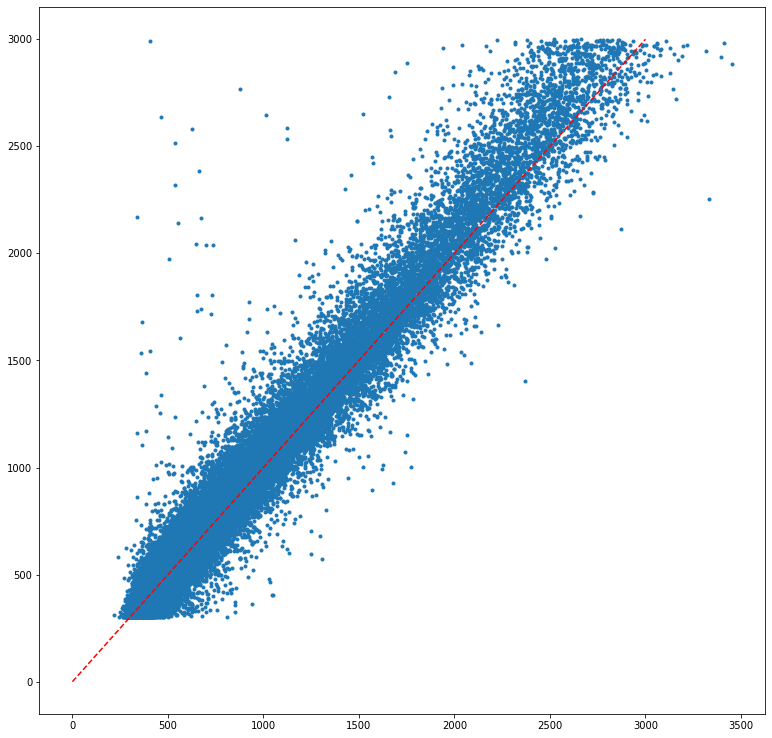

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(pred,lab,".")
plt.plot([0,3000],[0,3000],"r--")

In [ ]:
np.corrcoef(pred[:,0],lab)

array([[1.        , 0.98246276],
       [0.98246276, 1.        ]])

[(380.13614, 382.90000000000003), (890.2721, 891.5), (2240.8735, 2440.5), (565.1089, 579.2), (421.7175, 479.7), (392.16818, 401.1), (2174.2314, 2144.1), (763.46594, 864.0), (404.803, 522.9), (716.64874, 638.5), (384.87805, 426.5), (303.65652, 303.8), (782.2837, 733.1), (1396.1339, 1681.8999999999999), (721.5306, 731.8), (331.44922, 376.90000000000003), (414.03632, 411.9), (345.53174, 349.1), (1182.6967, 980.6), (459.2441, 674.3), (572.8637, 615.7), (709.2292, 763.5), (628.1701, 676.6), (535.35254, 501.2), (456.56876, 456.2), (608.9027, 675.8), (792.6047, 734.8), (429.5861, 528.5999999999999), (451.29724, 435.0), (672.25616, 728.6)] 



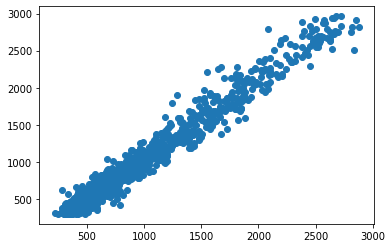

In [ ]:
print(list(zip(pred[60:90][:,0],lab[60:90])),"\n")
plt.scatter(pred[60:1900][:,0],lab[60:1900])

In [ ]:
del x_train,x_test,y_train,y_test

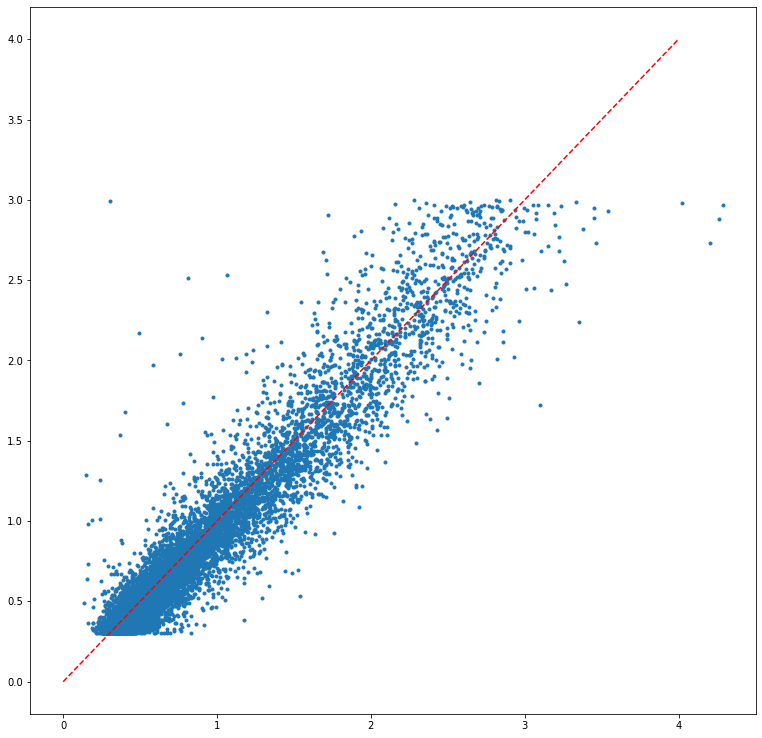

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(y_pred,y_test,".")
plt.plot([0,4],[0,4],"r--")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


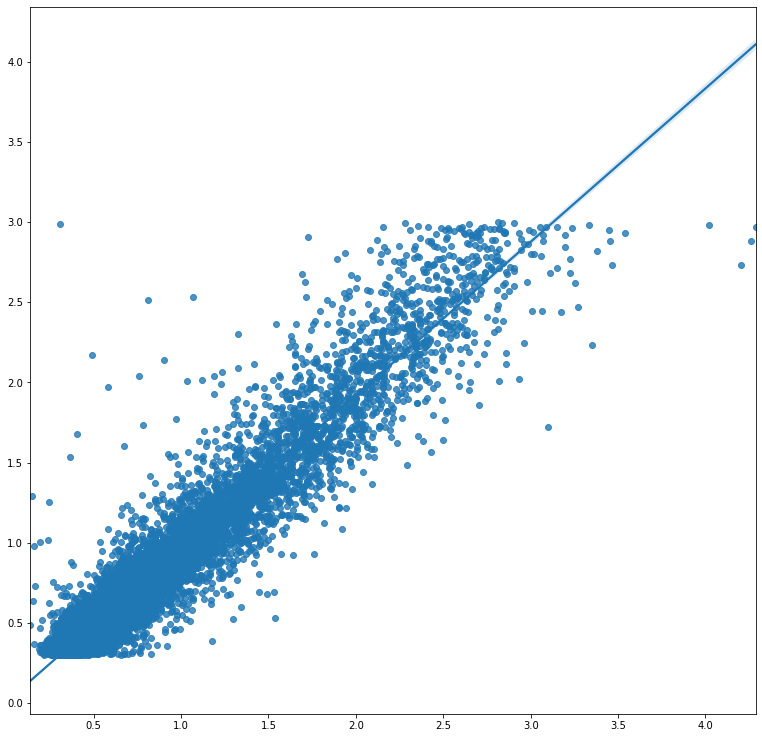

In [ ]:
import seaborn as sns
plt.figure(figsize=(13,13))
sns.regplot(y_pred,y_test)

In [ ]:
model_loaded=tf.keras.models.load_model(f"{base_dir}/model_predict_energy_1.h5")

In [ ]:
for i in range(0,140):
    print(y_test[i],y_predict[i][0])

476.2 757.21375
474.3 389.6309
537.4 521.20374
624.4 758.8094
445.5 667.4223
837.8 1451.2441
1136.5 638.8731
778.5999999999999 368.12238
791.2 820.1495
324.2 424.09784
373.09999999999997 1737.3335
344.7 364.1868
561.9 818.1297
527.5 391.8641
419.59999999999997 657.00146
477.3 355.75647
400.8 1042.9744
580.5 1220.8068
596.0999999999999 1045.2289
478.3 477.97354
1188.6000000000001 2464.4856
516.7 402.05356
597.8 537.2097
1543.0 530.7054
538.2 669.5558
549.3 398.59537
898.8000000000001 340.30966
1235.8 345.7743
370.5 949.73944
507.6 452.53204
580.3000000000001 485.80112
2969.6 1952.6941
836.3000000000001 757.067
736.3 562.4992
961.7 2032.8098
1203.2 470.24203
2235.3999999999996 658.0851
650.5 355.72217
2224.6 622.15875
589.7 587.5991
474.5 409.74808
400.3 515.7346
2175.6000000000004 358.12958
933.2 329.2159
538.6999999999999 643.59534
802.8 552.4719
363.5 506.86603
643.9 334.0934
442.3 1897.4215
1446.5 548.4808
566.6 416.78564
337.1 492.78262
336.6 563.8778
529.0 430.17047
436.59999999999

## Vamos a ver como de mejor estar nuestro método de la intuición venida de sumar intensidades



In [ ]:
#tenemso una predicción sobre todos los datos
y_predict=model.predict(dat)
#tenemos los valores reales "lab"
#tenemos una estimacion data por la suma de intensidades
#queremos conocer la formula de esa aproximacion
ajuste=np.polyfit(lab,suma_intensidades,1)

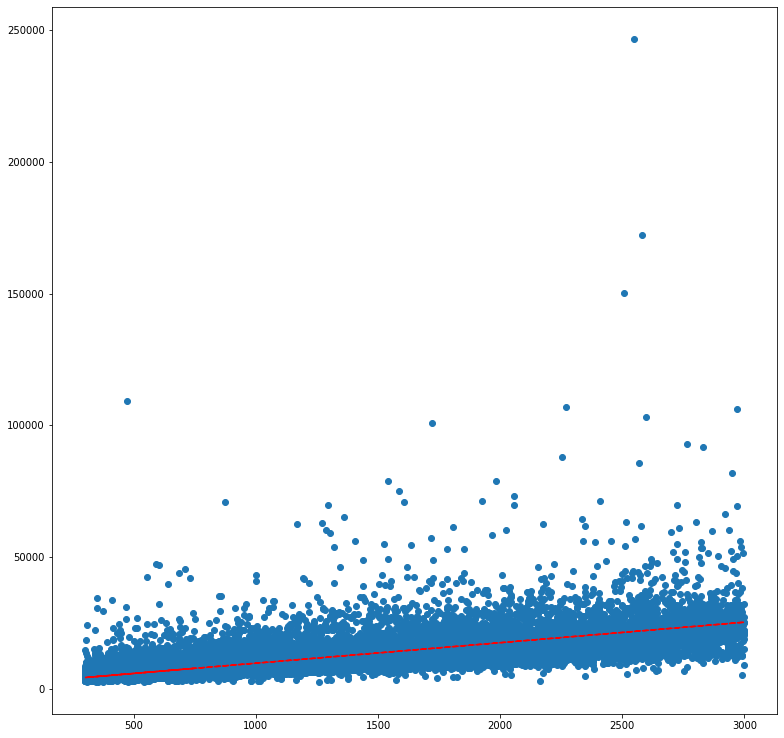

In [ ]:
#el ajuste anterior no da la sigueinte regresion
plt.figure(figsize=(13,13))
plt.scatter(lab,suma_intensidades)
plt.plot(lab,[ajuste[0]*i+ajuste[1] for i in lab],"r--")

(0.0, 3000.0)

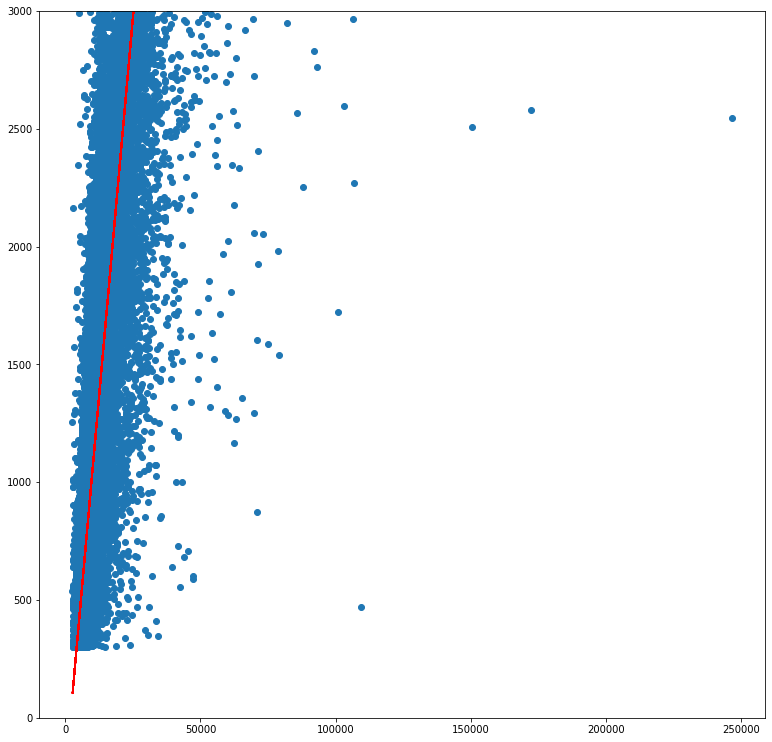

In [ ]:
#dado este ajuste podemos reordenar para que con un valor d esuma de pixeles nos de el valor de energia
prediccion=[(i-ajuste[1])/ajuste[0] for i in suma_intensidades]
plt.figure(figsize=(13,13))
plt.scatter(suma_intensidades,lab)
plt.plot(suma_intensidades,prediccion,"r--")
plt.ylim([0,3000])


In [ ]:
#como de lineal es esta relacion entre los datos
np.corrcoef(suma_intensidades,lab)

array([[1.        , 0.79470033],
       [0.79470033, 1.        ]])

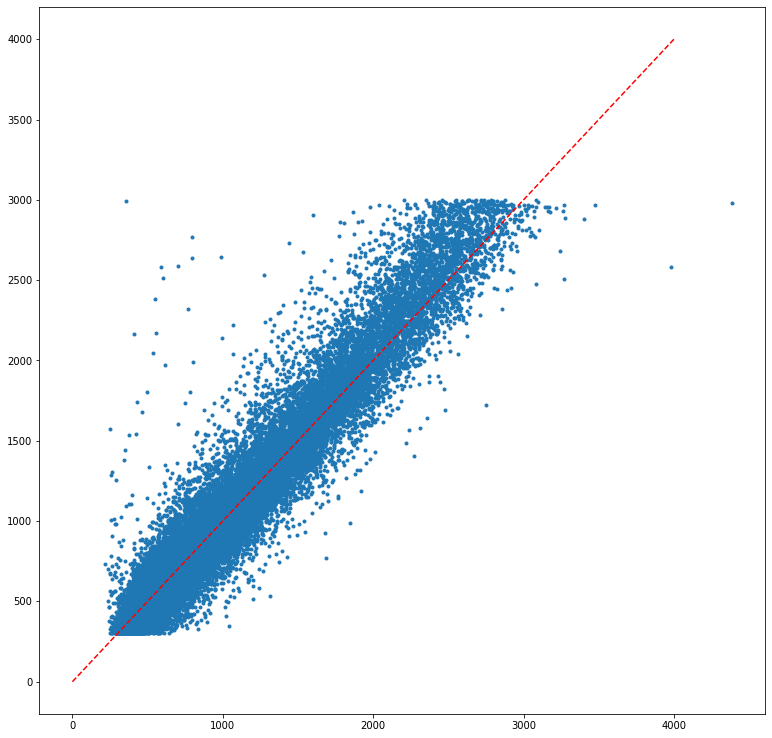

In [ ]:
#luego hacemos la predicción con nuestro modelo y obtenemos 
plt.figure(figsize=(13,13))
plt.plot(y_predict[:,0],lab,".")
plt.plot([0,4000],[0,4000],"r--")


In [ ]:
np.corrcoef(y_predict[:,0],lab)
#este resultado es mucho mejor que el otro se asemeja muchos mejor a una linea recta sin duda


array([[1.        , 0.97367171],
       [0.97367171, 1.        ]])

In [ ]:
#y cuales son los errores cuadraticos medios y la xi cuadrada y todo eso ?
xi_square=stats.chisquare(y_predict[:,0],lab)
mse_red=(((y_predict[:,0]-lab)**2).mean())
mse_intens=(((suma_intensidades-lab)**2).mean())
print(mse_intens,mse_red)

In [ ]:
#vamos como hay algunos que se alejan demasiado, vamos a cortar por los 62000, asi nos quitamos de rollos
mask= suma_intensidades<40000
new_lab=lab[mask]
new_suma_intensidades=suma_intensidades[mask]

(0.0, 3000.0)

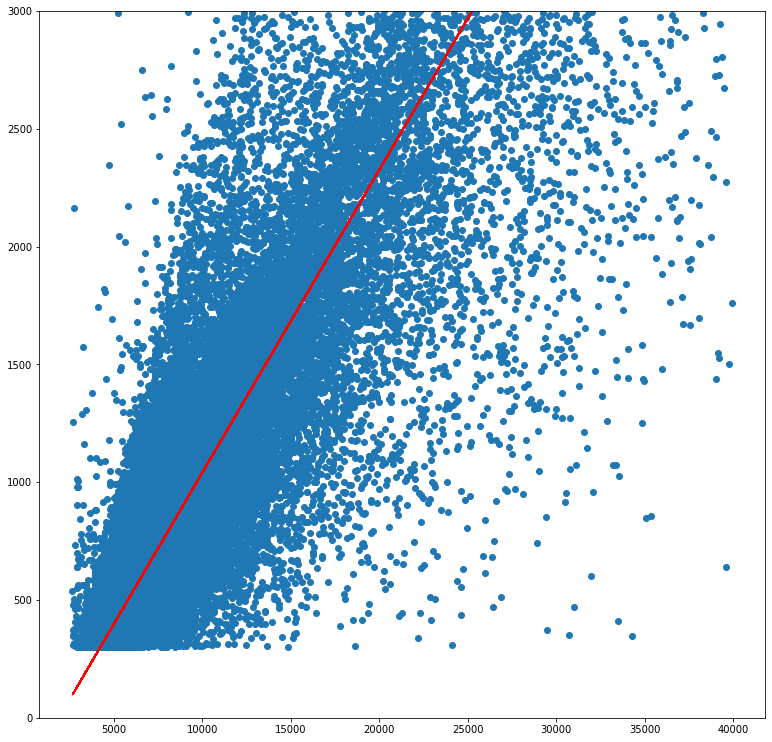

In [ ]:
#vamos a probar todo lo anterior a ver 
#dado este ajuste podemos reordenar para que con un valor d esuma de pixeles nos de el valor de energia

ajuste=np.polyfit(lab,suma_intensidades,1)
prediccion=[(i-ajuste[1])/ajuste[0] for i in new_suma_intensidades]
plt.figure(figsize=(13,13))
plt.scatter(new_suma_intensidades,new_lab)
plt.plot(new_suma_intensidades,prediccion,"r--")
plt.ylim([0,3000])


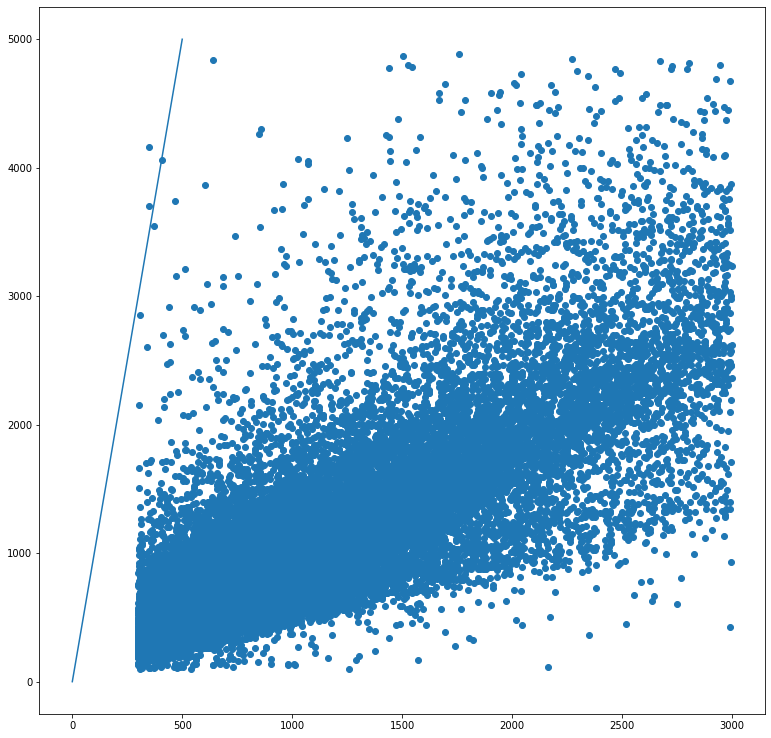

In [ ]:
plt.figure(figsize=(13,13))
plt.scatter(new_lab,prediccion)
plt.plot([0,500],[0,5000])

In [ ]:
#vamos a ver como de correlacionado estan los resultados para la nueva intensidad y las labels
np.corrcoef(new_lab,new_suma_intensidades)
#mucho mejor mero aun así con el model teniamos algo mejor aun y no teniamos que eliminar medidas.

array([[1.        , 0.85717033],
       [0.85717033, 1.        ]])

In [ ]:
#y cuales son los errores cuadraticos medios y la xi cuadrada y todo eso ?
xi_square=stats.chisquare(y_predict[:,0],lab)
mse_red=(((y_predict[:,0]-lab)**2).mean())
mse_intens=(((new_suma_intensidades-new_lab)**2).mean())
print(mse_intens,mse_red)

# Entrenamiento 1.2, características...



In [ ]:
#cargamos los datos

datos=sorted(glob.glob(f"{npy_sin_norm}/aux_npy*tel_*_run_*.npy"))
labels=sorted(glob.glob(f"{npy_sin_norm}/event*tel_*_run_*.npy"))
dat1=np.load(datos[0])
lab=np.load(labels[0])[:,1]
suma_intensidades=[[np.sum(i) for i in dat1]]
if dat1.shape[0]!= lab.shape[0]:
    print("LAS DIMENSIONES ESTÁN MAL, LA PRIMERA QUE COJAS DEBE ESTAR BIEN")
print(dat1.shape,lab.shape)
for i in range(1,len(datos)):
    aux_dat=np.load(datos[i])
    aux_lab=np.load(labels[i])[:,1]
    if aux_dat.shape[0]== aux_lab.shape[0]:
        suma_intensidades.append([np.sum(j) for j in aux_dat])
        dat1=np.concatenate((dat1,aux_dat))
        lab=np.concatenate((lab,aux_lab))
        print(len(suma_intensidades),dat1.shape,lab.shape)
    else:
        pass
    del aux_dat, aux_lab
suma_intensidades=np.concatenate(suma_intensidades)
dat=dat1[...,np.newaxis]
del dat1

(1999, 55, 93) (1999,)
2 (3998, 55, 93) (3998,)
3 (5997, 55, 93) (5997,)
4 (7995, 55, 93) (7995,)
5 (9994, 55, 93) (9994,)
6 (11993, 55, 93) (11993,)
7 (13992, 55, 93) (13992,)
8 (15991, 55, 93) (15991,)
9 (17989, 55, 93) (17989,)
10 (19988, 55, 93) (19988,)
11 (21987, 55, 93) (21987,)
12 (23986, 55, 93) (23986,)
13 (25985, 55, 93) (25985,)
14 (27983, 55, 93) (27983,)
15 (29982, 55, 93) (29982,)
16 (31981, 55, 93) (31981,)
17 (33978, 55, 93) (33978,)
18 (35977, 55, 93) (35977,)
19 (37976, 55, 93) (37976,)
20 (39975, 55, 93) (39975,)
21 (41973, 55, 93) (41973,)
22 (43972, 55, 93) (43972,)
23 (45971, 55, 93) (45971,)
24 (47970, 55, 93) (47970,)
25 (49969, 55, 93) (49969,)
26 (51968, 55, 93) (51968,)
27 (53966, 55, 93) (53966,)
28 (55965, 55, 93) (55965,)
29 (57964, 55, 93) (57964,)
30 (59963, 55, 93) (59963,)
31 (61962, 55, 93) (61962,)
32 (63960, 55, 93) (63960,)
33 (65958, 55, 93) (65958,)
34 (67956, 55, 93) (67956,)
35 (69955, 55, 93) (69955,)
36 (71954, 55, 93) (71954,)
37 (73953, 55

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(dat,lab,test_size=0.33,random_state=42)
del dat, lab

NameError: ignored

In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64,kernel_size=5,padding="same", input_shape=(55,93,1),activation="relu"))
#model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(16,kernel_size=5,padding="same",activation="relu"))
#model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(32,kernel_size=3,activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50,activation="relu"))
model.add(tf.keras.layers.Dense(50))
model.add(tf.keras.layers.Dense(10,activation="relu"))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 93, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 93, 16)        25616     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 91, 32)        4640      
_________________________________________________________________
dropout (Dropout)            (None, 53, 91, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 154336)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                7716850   
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(patience=7)
model.compile(optimizer="adam",loss="mae")

In [ ]:
history=model.fit(x_train,y_train,epochs=100,batch_size=128,callbacks=[stop],validation_data=(x_test,y_test))

Epoch 1/100
429/429 [==============================] - 65s 75ms/step - loss: 0.5837 - val_loss: 0.1185
Epoch 2/100
429/429 [==============================] - 31s 73ms/step - loss: 0.1178 - val_loss: 0.1072
Epoch 3/100
429/429 [==============================] - 33s 76ms/step - loss: 0.1094 - val_loss: 0.0976
Epoch 4/100
429/429 [==============================] - 32s 75ms/step - loss: 0.1032 - val_loss: 0.0949
Epoch 5/100
429/429 [==============================] - 32s 75ms/step - loss: 0.0972 - val_loss: 0.0936
Epoch 6/100
429/429 [==============================] - 32s 75ms/step - loss: 0.0944 - val_loss: 0.0948
Epoch 7/100
429/429 [==============================] - 32s 75ms/step - loss: 0.0925 - val_loss: 0.0930
Epoch 8/100
429/429 [==============================] - 32s 75ms/step - loss: 0.0891 - val_loss: 0.0926
Epoch 9/100
429/429 [==============================] - 32s 75ms/step - loss: 0.0869 - val_loss: 0.0910
Epoch 10/100
429/429 [==============================] - 32s 74ms/step - l

In [ ]:
model.save(f"{base_dir}/model_predict_energy_2.h5")

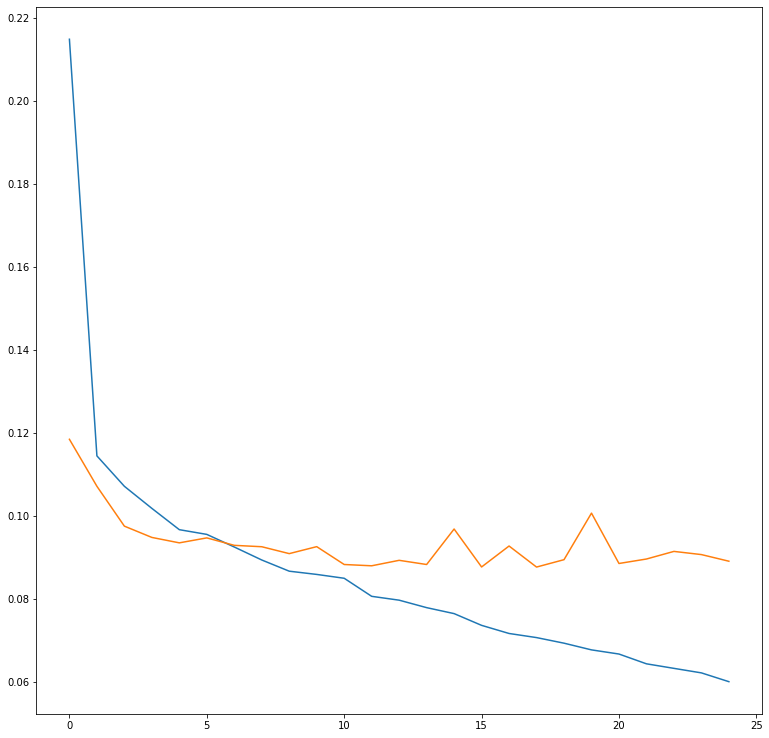

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

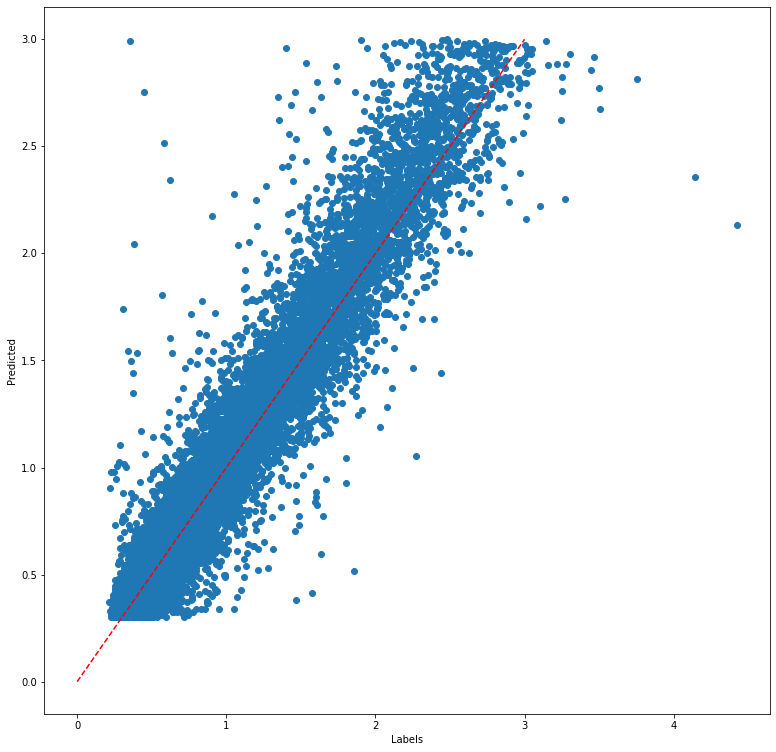

In [ ]:
#con este modelo vemos como de bien predice
plt.figure(figsize=(13,13))

predict=model.predict(x_test)
plt.scatter(predict,y_test)
plt.ylabel("Predicted")
plt.xlabel("Labels")
plt.plot([0,3],[0,3],"r--")

In [ ]:
#de este resultado podemos sacar informacion, como, que tal se ajusta a una dependencia lineal
np.corrcoef(predict[:,0],y_test)

array([[1.        , 0.96674906],
       [0.96674906, 1.        ]])

In [ ]:
!top

In [ ]:
del dat1,x_train,y_train

In [ ]:
#CONOCER LAS VARIABLES DEFINIDAS Y SUS PESOS
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

In [ ]:
#calculamos el error cuadratico medio
((predict[:,0]-y_test)**2).mean()

19839.1119525676

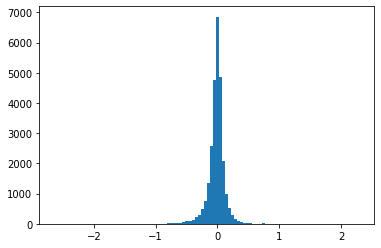

In [ ]:
#veamos como se distribuyen las diferencias
difs=(predict[:,0]-y_test)
plt.hist(difs,100);

los datos estaban en TeV 1e12, pero los hemos multiplicado por 1e3 
asi que los datos ahora estan en 1e9


In [ ]:
#calculamos la media
print(difs.mean())
#calculamos el varianza
print(difs.var())
#y la desciacion estandar
print(difs.std())

-0.0189685335828466
0.020596235065761803
0.14351388457484454


Tenemos que las diferencis entre lo predicho y lo real es viene dado por una gausiana sesgada con media (-44) y con desviacion estandar de 133 
e9 eV. Si sabemos que esta sesgado podemos ccorregirlo y si sabemos como se distribuye el error podemos dar un intervalo de confianza de dicha diferencia entre valor real y predicho,

In [ ]:
# que les pasa a aquellos qeu se desvian tanto de lo que debía ser, que ve la red en ellos para fallar tanto
#vamos a obtener los indices de los mayores y menores valores de difs y vamos a ver sus correspondientes imágenes
n=3
maximos=heapq.nlargest(n*n, enumerate(np.abs(difs)), key=lambda x: x[1])
indices=[i[0] for i in maximos]
indices

[20361, 425, 20659, 14615, 9197, 6396, 5995, 14489, 4297]

In [ ]:
predict

array([[0.60270035],
       [0.59320027],
       [0.450795  ],
       ...,
       [0.29435524],
       [0.6171965 ],
       [1.7431366 ]], dtype=float32)

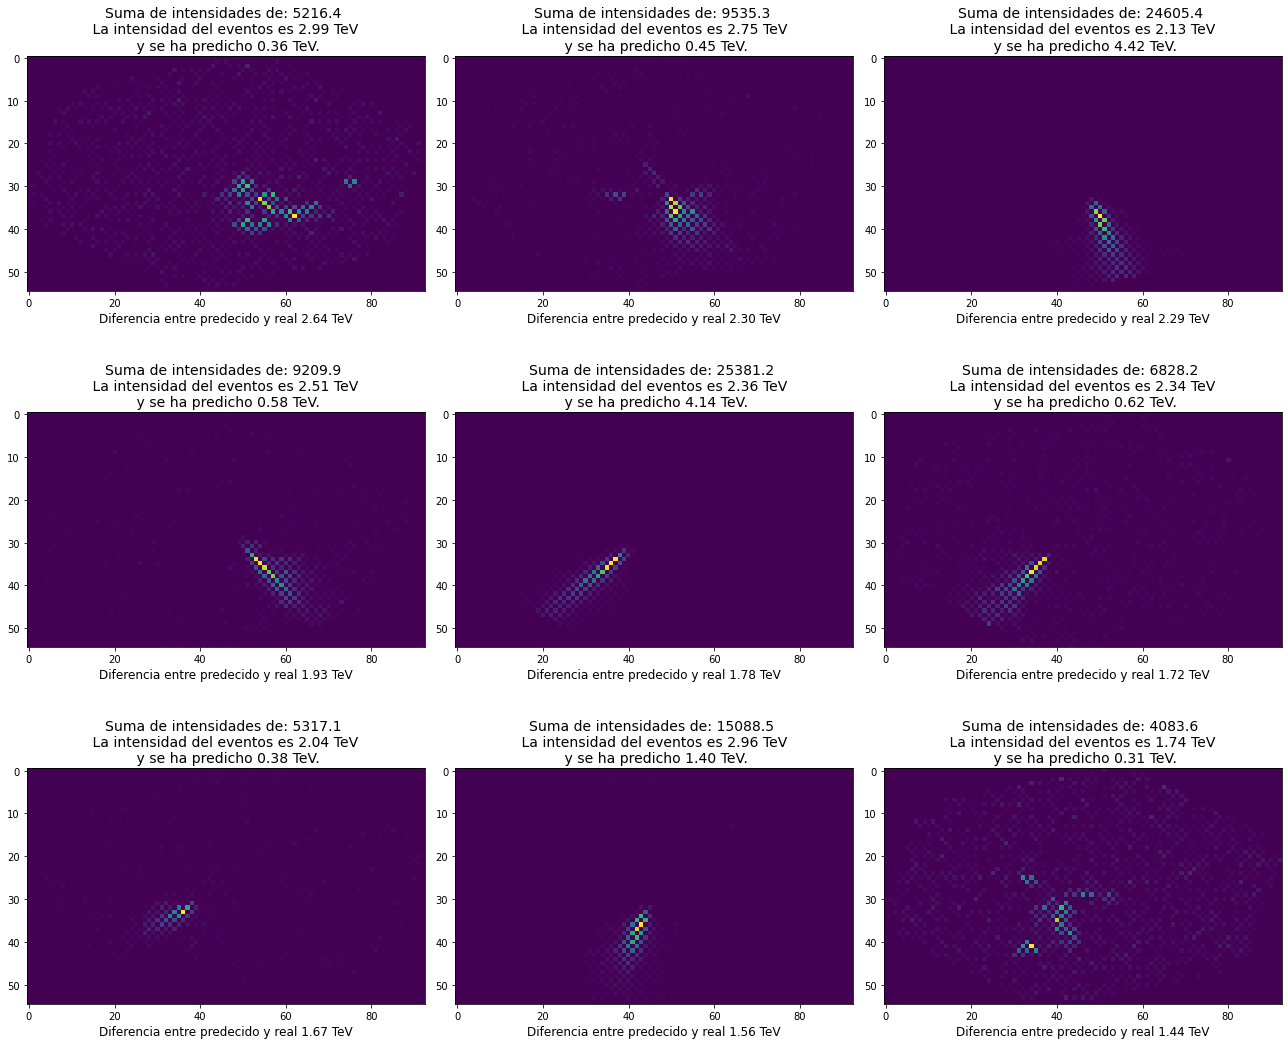

In [ ]:
plt.figure(figsize=(18,15))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(x_test[indices[i]][:,:,0])
    text=f"Suma de intensidades de: {np.sum(x_test[indices[i]][:,:,0]):.1f} \n La intensidad del eventos es {y_test[indices[i]]:.2f} TeV \n y se ha predicho {predict[indices[i]][0]:.2f} TeV."
    plt.xlabel(f"Diferencia entre predecido y real {maximos[i][1]:.2f} TeV",fontsize=12)
    plt.title(text,fontsize=14)
plt.tight_layout()

[(425, -1659.2433349609373),
 (5995, -1337.884521484375),
 (18559, -1237.4428466796876),
 (20361, -1046.102783203125),
 (14615, -1021.1418212890626),
 (11669, -925.29365234375),
 (4297, -907.138671875),
 (17296, -886.0173583984374),
 (18059, -864.6554077148437)]

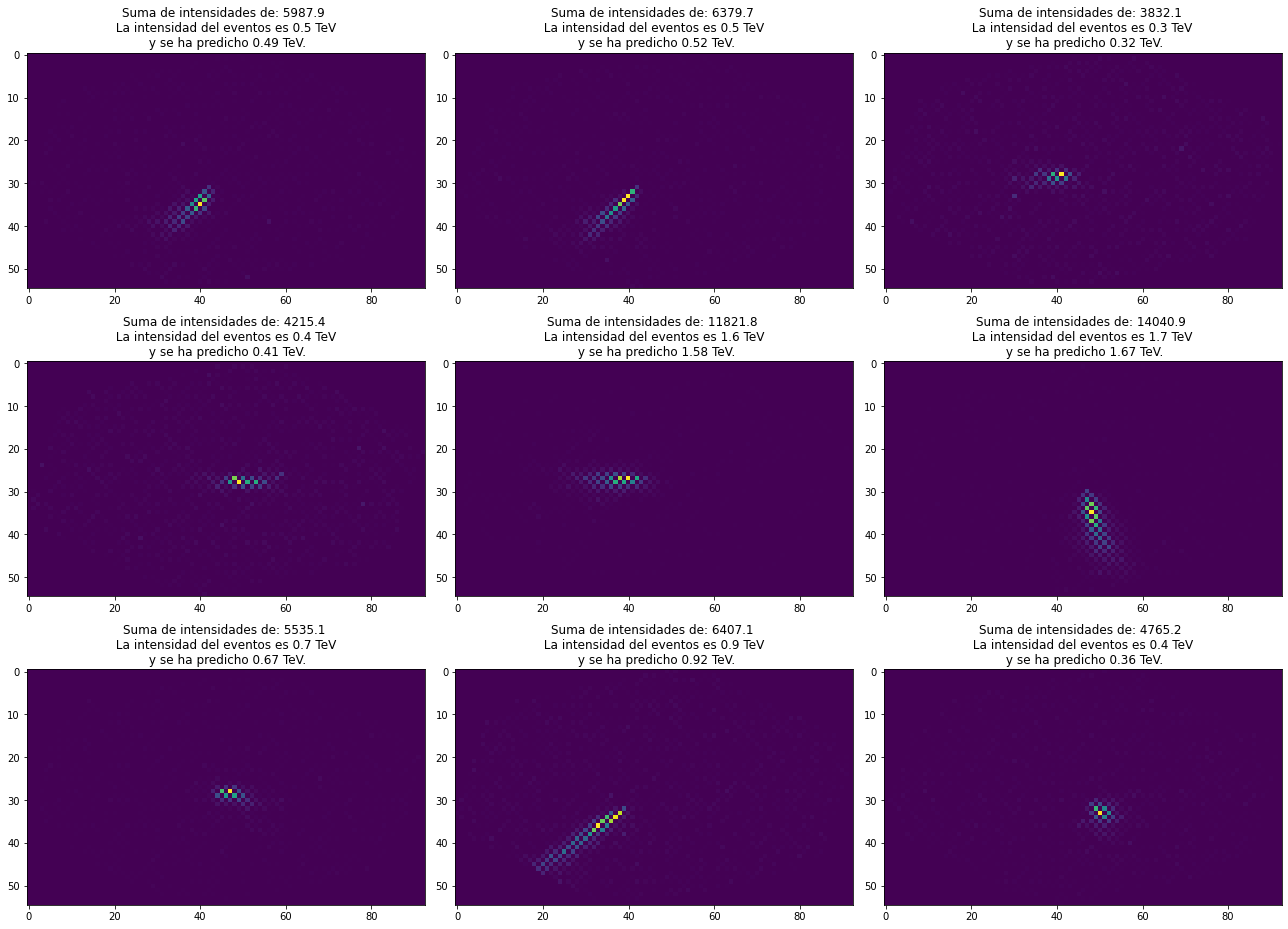

In [ ]:
#estos se han predicho muy bien
n=3
minimo=heapq.nsmallest(n*n, enumerate(abs(difs)), key=lambda x: x[1])
indices=[i[0] for i in minimo]
indices
plt.figure(figsize=(18,13))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(x_test[indices[i]][:,:,0])
    text=f"Suma de intensidades de: {np.sum(x_test[indices[i]][:,:,0]):.1f} \n La intensidad del eventos es {y_test[indices[i]]:.1f} TeV \n y se ha predicho {predict[indices[i]][0]:.2f} TeV."
    plt.title(text)

plt.tight_layout()

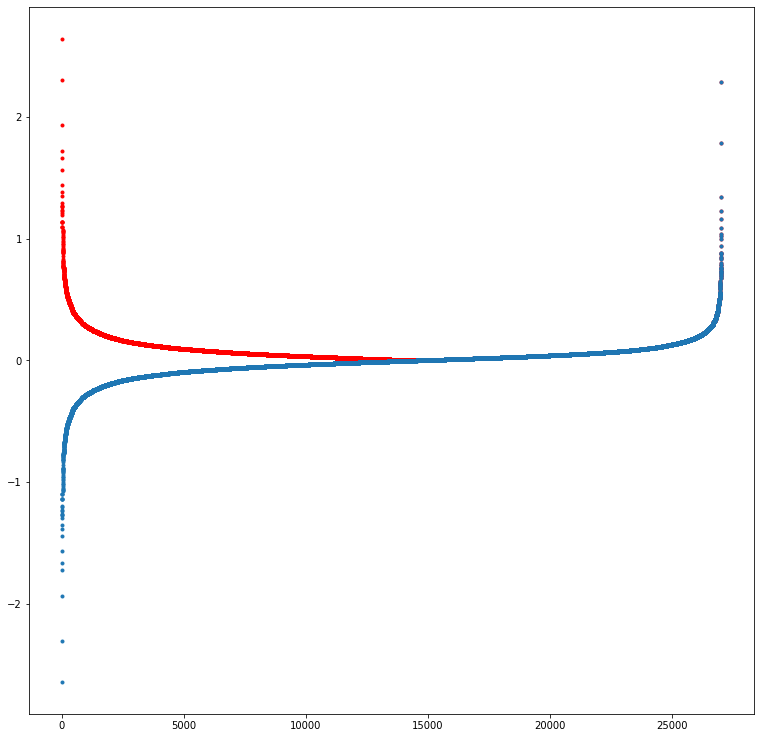

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(np.abs(sorted(difs)),"r.")
plt.plot(sorted(difs),".")

In [ ]:
#vamos a ver el error relativo de los resultados
err_rel=[100*abs(j)/y_test[i] for i ,j in enumerate(difs)]

Text(0, 0.5, 'Densidad de medidas con ese error relativo o menor \n (suman 1 el total)')

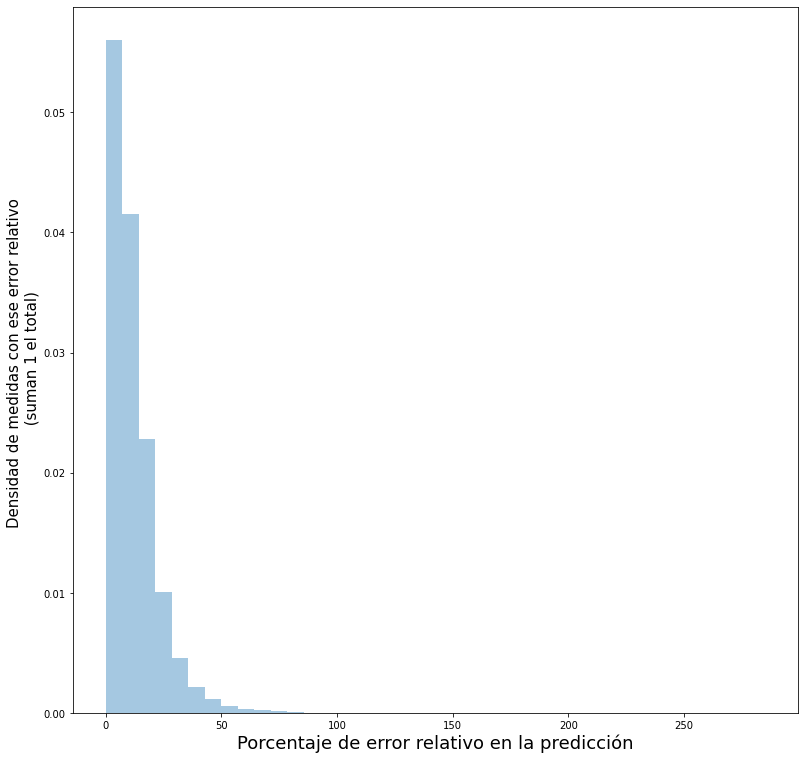

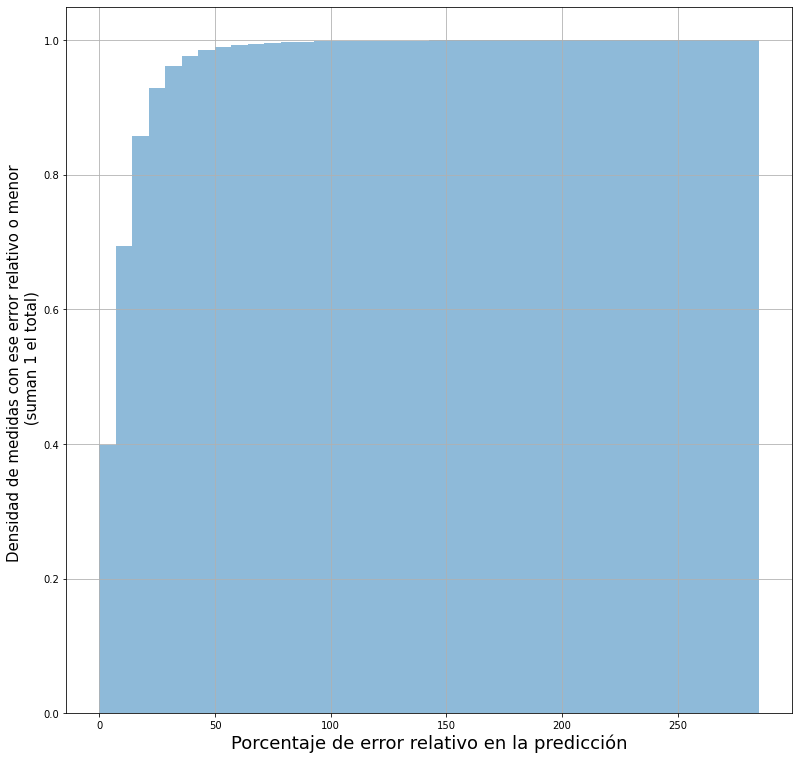

In [ ]:
plt.figure(figsize=(13,13))
plt.hist(err_rel,40,density=True,linestyle="solid",histtype="stepfilled",alpha=0.4);
plt.xlabel("Porcentaje de error relativo en la predicción",fontsize=18)
plt.ylabel("Densidad de medidas con ese error relativo \n (suman 1 el total)",fontsize=15)
plt.figure(figsize=(13,13))
datos_hist=plt.hist(err_rel,40,density=True,cumulative=True,linestyle="solid",histtype="stepfilled",alpha=0.5);
plt.grid()
plt.xlabel("Porcentaje de error relativo en la predicción",fontsize=18)
plt.ylabel("Densidad de medidas con ese error relativo o menor \n (suman 1 el total)",fontsize=15)

In [ ]:
datos_hist

(array([0.39895722, 0.69467145, 0.85707947, 0.92881707, 0.96165366,
        0.97736937, 0.98587435, 0.99042266, 0.99297415, 0.99508191,
        0.99659801, 0.99741153, 0.99785527, 0.99829901, 0.99866879,
        0.99900159, 0.99911252, 0.99922346, 0.99944533, 0.99963022,
        0.9996672 , 0.99970417, 0.99974115, 0.99977813, 0.99981511,
        0.99985209, 0.99985209, 0.99985209, 0.99985209, 0.99988907,
        0.99988907, 0.99988907, 0.99988907, 0.99988907, 0.99988907,
        0.99988907, 0.99992604, 0.99992604, 0.99992604, 1.        ]),
 array([3.11809301e-04, 7.12915840e+00, 1.42580050e+01, 2.13868516e+01,
        2.85156982e+01, 3.56445448e+01, 4.27733914e+01, 4.99022380e+01,
        5.70310845e+01, 6.41599311e+01, 7.12887777e+01, 7.84176243e+01,
        8.55464709e+01, 9.26753175e+01, 9.98041641e+01, 1.06933011e+02,
        1.14061857e+02, 1.21190704e+02, 1.28319550e+02, 1.35448397e+02,
        1.42577244e+02, 1.49706090e+02, 1.56834937e+02, 1.63963783e+02,
        1.71092630e+02

In [ ]:
modelo_1_2=np.array([np.array([0.39895722, 0.69467145, 0.85707947, 0.92881707, 0.96165366,
        0.97736937, 0.98587435, 0.99042266, 0.99297415, 0.99508191,
        0.99659801, 0.99741153, 0.99785527, 0.99829901, 0.99866879,
        0.99900159, 0.99911252, 0.99922346, 0.99944533, 0.99963022,
        0.9996672 , 0.99970417, 0.99974115, 0.99977813, 0.99981511,
        0.99985209, 0.99985209, 0.99985209, 0.99985209, 0.99988907,
        0.99988907, 0.99988907, 0.99988907, 0.99988907, 0.99988907,
        0.99988907, 0.99992604, 0.99992604, 0.99992604, 1.        ]),
 np.array([3.11809301e-04, 7.12915840e+00, 1.42580050e+01, 2.13868516e+01,
        2.85156982e+01, 3.56445448e+01, 4.27733914e+01, 4.99022380e+01,
        5.70310845e+01, 6.41599311e+01, 7.12887777e+01, 7.84176243e+01,
        8.55464709e+01, 9.26753175e+01, 9.98041641e+01, 1.06933011e+02,
        1.14061857e+02, 1.21190704e+02, 1.28319550e+02, 1.35448397e+02,
        1.42577244e+02, 1.49706090e+02, 1.56834937e+02, 1.63963783e+02,
        1.71092630e+02, 1.78221477e+02, 1.85350323e+02, 1.92479170e+02,
        1.99608016e+02, 2.06736863e+02, 2.13865710e+02, 2.20994556e+02,
        2.28123403e+02, 2.35252249e+02, 2.42381096e+02, 2.49509943e+02,
        2.56638789e+02, 2.63767636e+02, 2.70896482e+02, 2.78025329e+02,
        2.85154175e+02])])

In [ ]:
modelo_1=np.array([np.array([0.21347484, 0.40953297, 0.57770957, 0.71597086, 0.82782975,
        0.89021188, 0.92378804, 0.94878527, 0.96461191, 0.97533558,
        0.98195466, 0.98642902, 0.98923936, 0.99197574, 0.99397256,
        0.99522982, 0.99633916, 0.99737455, 0.99774433, 0.99837296,
        0.99863181, 0.99903857, 0.99940835, 0.99955626, 0.99959324,
        0.99974115, 0.99977813, 0.99981511, 0.99985209, 0.99988907,
        0.99988907, 0.99988907, 0.99988907, 0.99988907, 0.99996302,
        0.99996302, 0.99996302, 0.99996302, 0.99996302, 1.        ]),
 np.array([3.44605581e-04, 5.23455498e+00, 1.04687654e+01, 1.57029757e+01,
        2.09371861e+01, 2.61713965e+01, 3.14056069e+01, 3.66398172e+01,
        4.18740276e+01, 4.71082380e+01, 5.23424483e+01, 5.75766587e+01,
        6.28108691e+01, 6.80450795e+01, 7.32792898e+01, 7.85135002e+01,
        8.37477106e+01, 8.89819210e+01, 9.42161313e+01, 9.94503417e+01,
        1.04684552e+02, 1.09918762e+02, 1.15152973e+02, 1.20387183e+02,
        1.25621394e+02, 1.30855604e+02, 1.36089814e+02, 1.41324025e+02,
        1.46558235e+02, 1.51792445e+02, 1.57026656e+02, 1.62260866e+02,
        1.67495077e+02, 1.72729287e+02, 1.77963497e+02, 1.83197708e+02,
        1.88431918e+02, 1.93666128e+02, 1.98900339e+02, 2.04134549e+02,
        2.09368760e+02])])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Entrenamiento 1.3, características...



In [ ]:
#del x_train,x_test,y_train,y_test

In [ ]:
#cargamos los datos

datos=sorted(glob.glob(f"{npy_sin_norm}/aux_npy*tel_*_run_*.npy"))
labels=sorted(glob.glob(f"{npy_sin_norm}/event*tel_*_run_*.npy"))
dat1=np.load(datos[0])
lab=np.load(labels[0])[:,1]
suma_intensidades=[[np.sum(i) for i in dat1]]
if dat1.shape[0]!= lab.shape[0]:
    print("LAS DIMENSIONES ESTÁN MAL, LA PRIMERA QUE COJAS DEBE ESTAR BIEN")
print(dat1.shape,lab.shape)
for i in range(1,len(datos)):
    aux_dat=np.load(datos[i])
    aux_lab=np.load(labels[i])[:,1]
    if aux_dat.shape[0]== aux_lab.shape[0]:
        suma_intensidades.append([np.sum(j) for j in aux_dat])
        dat1=np.concatenate((dat1,aux_dat))
        lab=np.concatenate((lab,aux_lab))
        print(len(suma_intensidades),dat1.shape,lab.shape)
    else:
        pass
    del aux_dat, aux_lab
suma_intensidades=np.concatenate(suma_intensidades)
dat=dat1[...,np.newaxis]
del dat1

(1999, 55, 93) (1999,)
2 (3998, 55, 93) (3998,)
3 (5997, 55, 93) (5997,)
4 (7995, 55, 93) (7995,)
5 (9994, 55, 93) (9994,)
6 (11993, 55, 93) (11993,)
7 (13992, 55, 93) (13992,)
8 (15991, 55, 93) (15991,)
9 (17989, 55, 93) (17989,)
10 (19988, 55, 93) (19988,)
11 (21987, 55, 93) (21987,)
12 (23986, 55, 93) (23986,)
13 (25985, 55, 93) (25985,)
14 (27983, 55, 93) (27983,)
15 (29982, 55, 93) (29982,)
16 (31981, 55, 93) (31981,)
17 (33978, 55, 93) (33978,)
18 (35977, 55, 93) (35977,)
19 (37976, 55, 93) (37976,)
20 (39975, 55, 93) (39975,)
21 (41973, 55, 93) (41973,)
22 (43972, 55, 93) (43972,)
23 (45971, 55, 93) (45971,)
24 (47970, 55, 93) (47970,)
25 (49969, 55, 93) (49969,)
26 (51968, 55, 93) (51968,)
27 (53966, 55, 93) (53966,)
28 (55965, 55, 93) (55965,)
29 (57964, 55, 93) (57964,)
30 (59963, 55, 93) (59963,)
31 (61962, 55, 93) (61962,)
32 (63960, 55, 93) (63960,)
33 (65958, 55, 93) (65958,)
34 (67956, 55, 93) (67956,)
35 (69955, 55, 93) (69955,)
36 (71954, 55, 93) (71954,)
37 (73953, 55

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(dat,lab,test_size=0.33,random_state=42)
del dat, lab

In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,kernel_size=3,padding="same", input_shape=(55,93,1),activation="relu"))
model.add(tf.keras.layers.AveragePooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(32,kernel_size=5,padding="same",activation="relu"))
model.add(tf.keras.layers.AveragePooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(16,kernel_size=3,activation="relu"))
model.add(tf.keras.layers.Dropout(0.35))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100,activation="relu"))
model.add(tf.keras.layers.Dense(20,activation="relu"))
model.add(tf.keras.layers.Dense(1))

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(patience=7)
model.compile(optimizer="adam",loss="mae")

In [ ]:
history=model.fit(x_train,y_train,epochs=100,batch_size=64,callbacks=[stop],validation_data=(x_test,y_test))

Epoch 1/100
858/858 [==============================] - 19s 21ms/step - loss: 0.0814 - val_loss: 0.0797
Epoch 2/100
858/858 [==============================] - 18s 21ms/step - loss: 0.0811 - val_loss: 0.0800
Epoch 3/100
858/858 [==============================] - 17s 20ms/step - loss: 0.0812 - val_loss: 0.0784
Epoch 4/100
858/858 [==============================] - 18s 21ms/step - loss: 0.0814 - val_loss: 0.0773
Epoch 5/100
858/858 [==============================] - 18s 21ms/step - loss: 0.0804 - val_loss: 0.0793
Epoch 6/100
858/858 [==============================] - 19s 22ms/step - loss: 0.0812 - val_loss: 0.0805
Epoch 7/100
858/858 [==============================] - 18s 21ms/step - loss: 0.0801 - val_loss: 0.0801
Epoch 8/100
858/858 [==============================] - 18s 21ms/step - loss: 0.0802 - val_loss: 0.0832
Epoch 9/100
858/858 [==============================] - 18s 21ms/step - loss: 0.0802 - val_loss: 0.0780
Epoch 10/100
858/858 [==============================] - 18s 21ms/step - l

In [ ]:
#model.save(f"{base_dir}/model_predict_energy_2.h5")

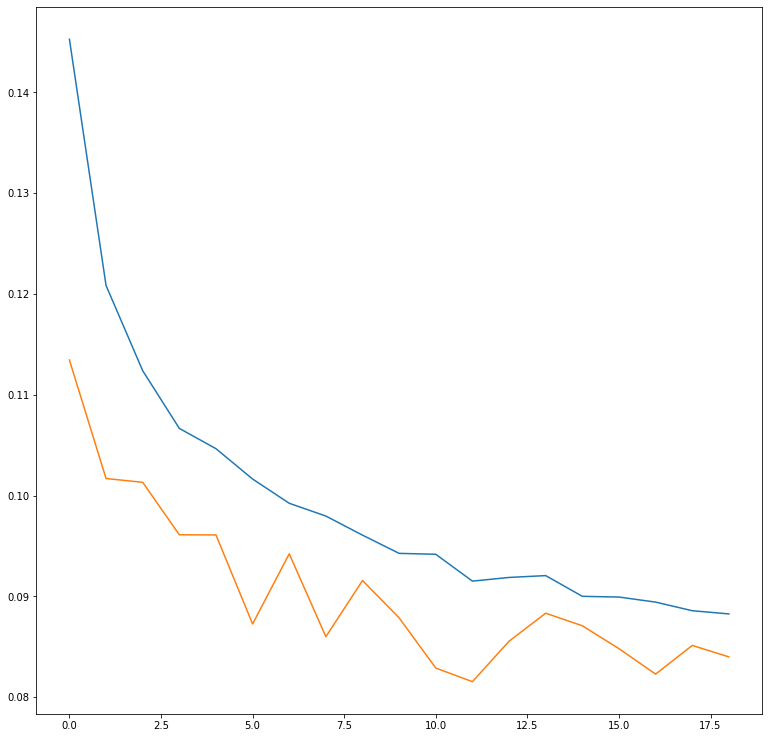

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

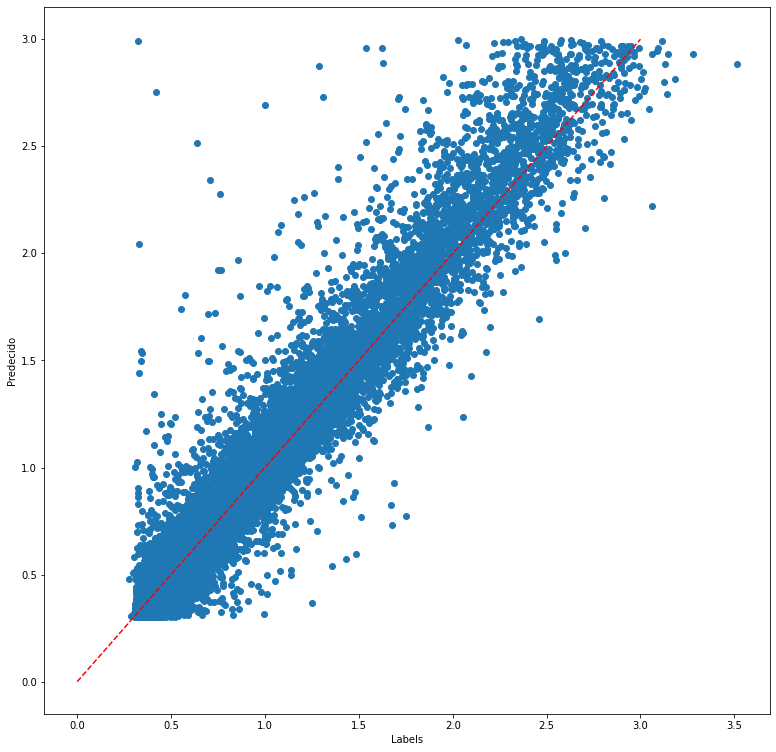

In [ ]:
#con este modelo vemos como de bien predice
plt.figure(figsize=(13,13))

predict=model.predict(x_test)
plt.scatter(predict,y_test)
plt.ylabel("Predecido")
plt.xlabel("Labels")
plt.plot([0,3],[0,3],"r--")

In [ ]:
#de este resultado podemos sacar informacion, como, que tal se ajusta a una dependencia lineal
np.corrcoef(predict[:,0],y_test)

array([[1.       , 0.9732531],
       [0.9732531, 1.       ]])

In [ ]:
!top

In [ ]:
del dat1,x_train,y_train

In [ ]:
#CONOCER LAS VARIABLES DEFINIDAS Y SUS PESOS
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

In [ ]:
#calculamos el error cuadratico medio
((predict[:,0]-y_test)**2).mean()

19839.1119525676

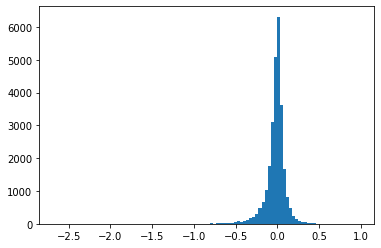

In [ ]:
#veamos como se distribuyen las diferencias
difs=(predict[:,0]-y_test)
plt.hist(difs,100);

los datos estaban en TeV 1e12, pero los hemos multiplicado por 1e3 
asi que los datos ahora estan en 1e9


In [ ]:
#calculamos la media
print(difs.mean())
#calculamos el varianza
print(difs.var())
#y la desciacion estandar
print(difs.std())

-0.023065412930169542
0.016794997409507184
0.12959551461955457


Tenemos que las diferencis entre lo predicho y lo real es viene dado por una gausiana sesgada con media (-44) y con desviacion estandar de 133 
e9 eV. Si sabemos que esta sesgado podemos ccorregirlo y si sabemos como se distribuye el error podemos dar un intervalo de confianza de dicha diferencia entre valor real y predicho,

In [ ]:
# que les pasa a aquellos qeu se desvian tanto de lo que debía ser, que ve la red en ellos para fallar tanto
#vamos a obtener los indices de los mayores y menores valores de difs y vamos a ver sus correspondientes imágenes
n=3
maximos=heapq.nlargest(n*n, enumerate(np.abs(difs)), key=lambda x: x[1])
indices=[i[0] for i in maximos]
indices

[20361, 425, 14615, 6396, 5995, 18559, 18737, 4297, 17296]

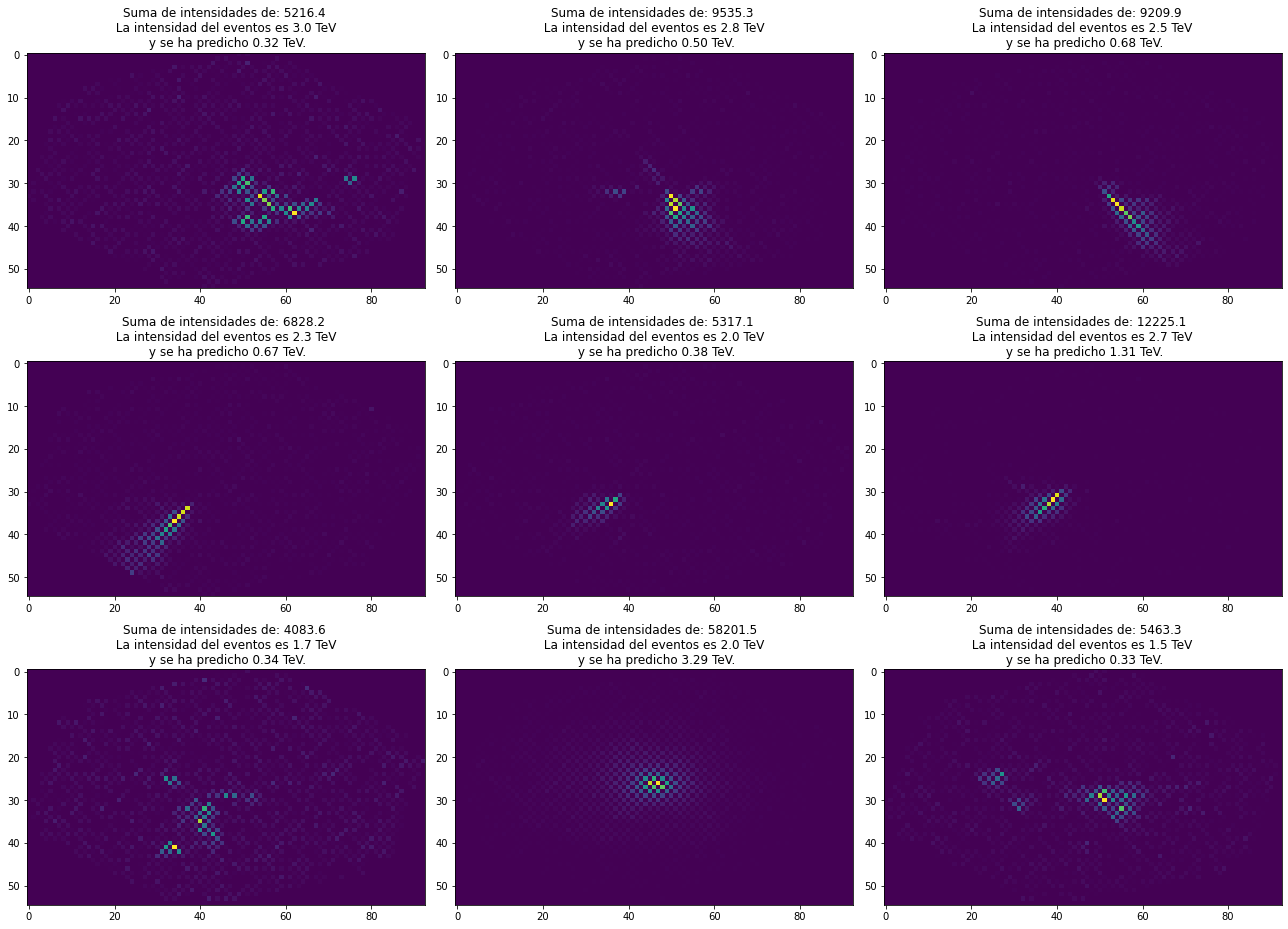

In [ ]:
plt.figure(figsize=(18,13))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(x_test[indices[i]][:,:,0])
    text=f"Suma de intensidades de: {np.sum(x_test[indices[i]][:,:,0]):.1f} \n La intensidad del eventos es {y_test[indices[i]]:.1f} TeV \n y se ha predicho {predict[indices[i]][0]:.2f} TeV."
    plt.title(text)
plt.tight_layout()

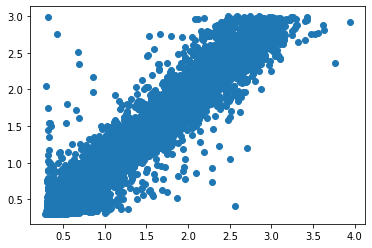

In [ ]:
plt.scatter(predict,y_test)

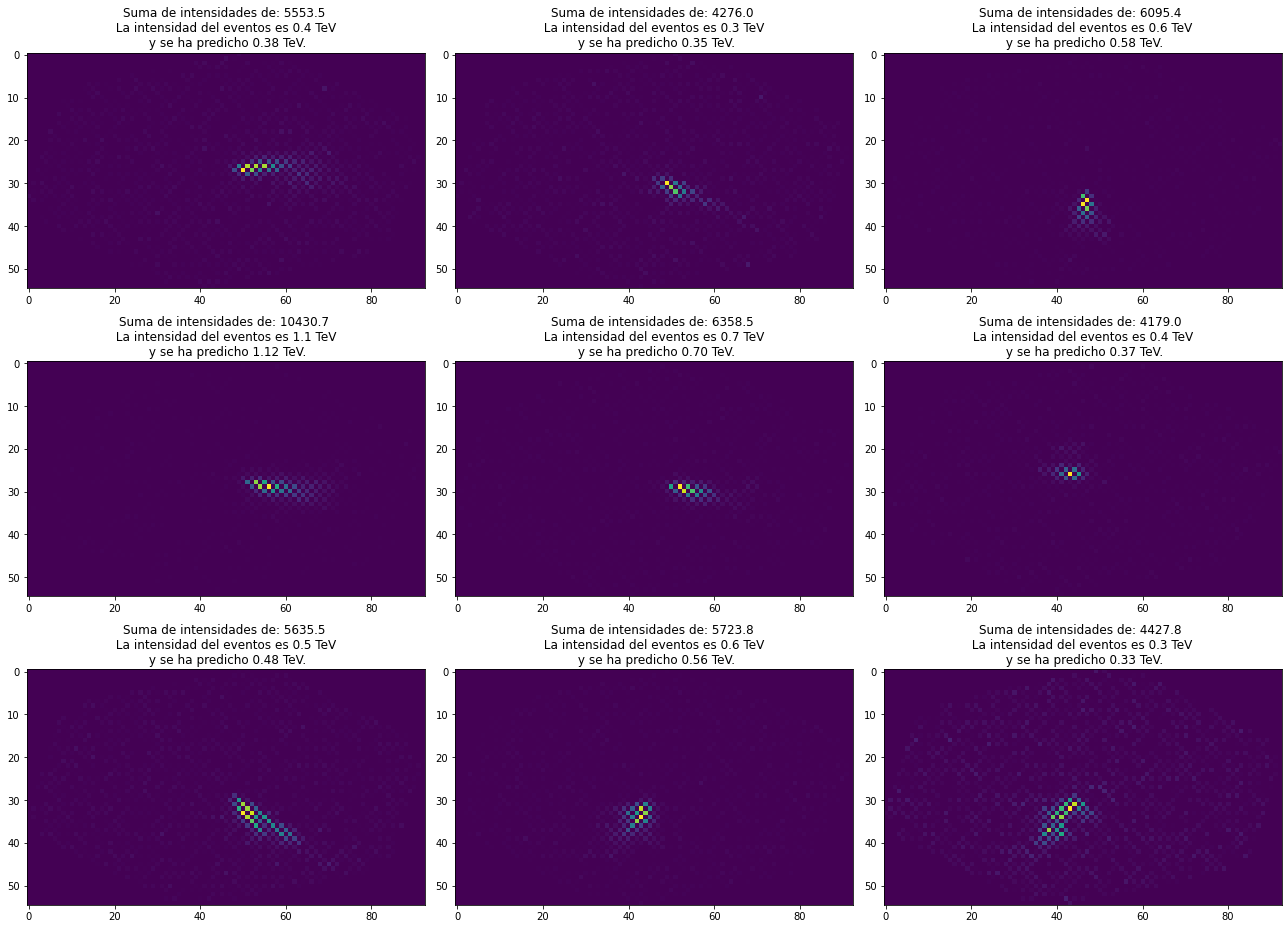

In [ ]:
#estos se han predicho muy bien
n=3
minimo=heapq.nsmallest(n*n, enumerate(abs(difs)), key=lambda x: x[1])
indices=[i[0] for i in minimo]
indices
plt.figure(figsize=(18,13))
for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(x_test[indices[i]][:,:,0])
    text=f"Suma de intensidades de: {np.sum(x_test[indices[i]][:,:,0]):.1f} \n La intensidad del eventos es {y_test[indices[i]]:.1f} TeV \n y se ha predicho {predict[indices[i]][0]:.2f} TeV."
    plt.title(text)

plt.tight_layout()

yo creo que la simplificacion en mi modelo no ayuda nada, el maxpooling nos quita mucha info

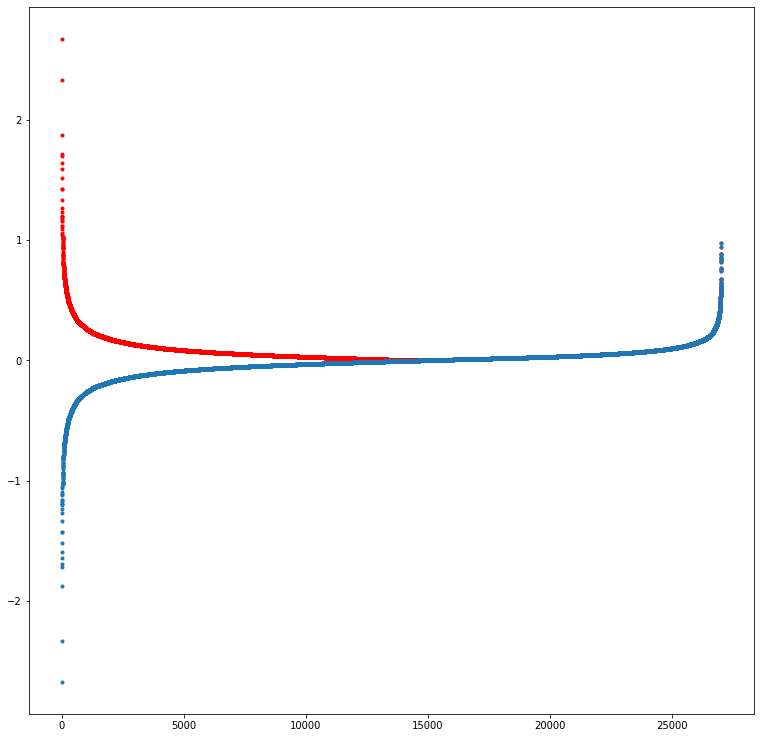

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(np.abs(sorted(difs)),"r.")
plt.plot(sorted(difs),".")

In [ ]:
#vamos a ver el error relativo de los resultados
err_rel=[100*abs(j)/y_test[i] for i ,j in enumerate(difs)]

Text(0, 0.5, 'Densidad de medidas con ese error relativo o menor \n (suman 1 el total)')

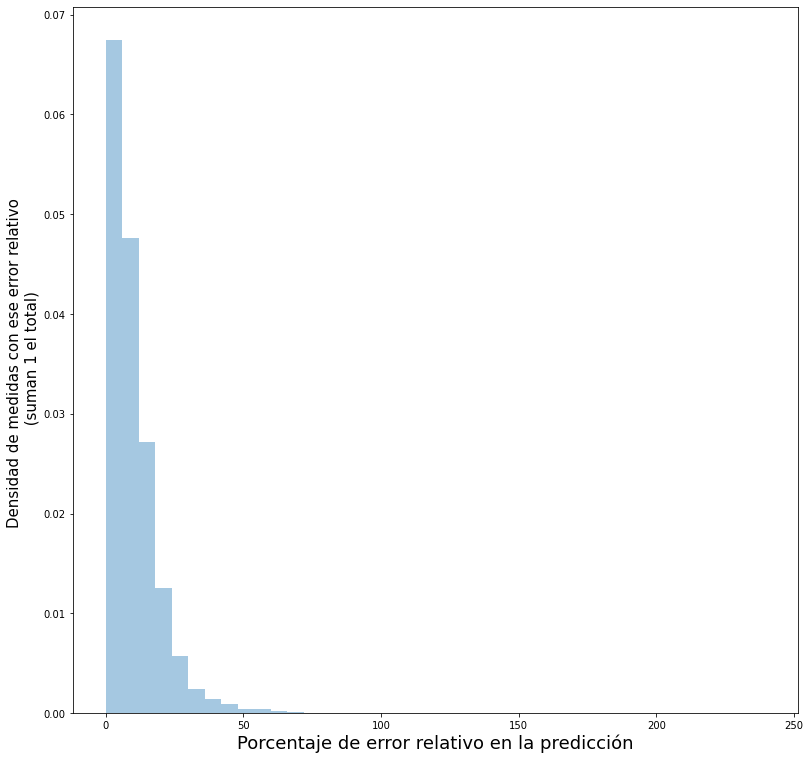

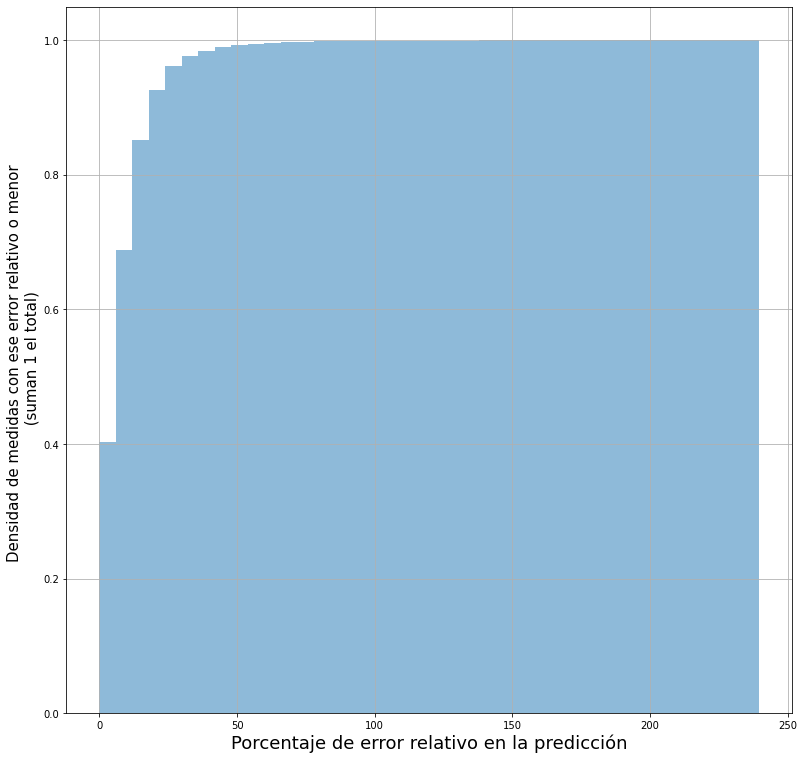

In [ ]:
plt.figure(figsize=(13,13))
plt.hist(err_rel,40,density=True,linestyle="solid",histtype="stepfilled",alpha=0.4);
plt.xlabel("Porcentaje de error relativo en la predicción",fontsize=18)
plt.ylabel("Densidad de medidas con ese error relativo \n (suman 1 el total)",fontsize=15)
plt.figure(figsize=(13,13))
datos_hist=plt.hist(err_rel,40,density=True,cumulative=True,linestyle="solid",histtype="stepfilled",alpha=0.5);
plt.grid()
plt.xlabel("Porcentaje de error relativo en la predicción",fontsize=18)
plt.ylabel("Densidad de medidas con ese error relativo o menor \n (suman 1 el total)",fontsize=15)

In [ ]:
datos_hist

(array([0.35162519, 0.63916725, 0.83056614, 0.92659838, 0.96742225,
        0.98347077, 0.99020079, 0.99352882, 0.99563658, 0.99656103,
        0.99700477, 0.99752246, 0.99807714, 0.99840994, 0.99877972,
        0.99889066, 0.99903857, 0.99926044, 0.99940835, 0.99944533,
        0.99951928, 0.99955626, 0.99959324, 0.99963022, 0.9996672 ,
        0.99974115, 0.99977813, 0.99981511, 0.99985209, 0.99985209,
        0.99992604, 0.99996302, 0.99996302, 0.99996302, 0.99996302,
        0.99996302, 0.99996302, 0.99996302, 0.99996302, 1.        ]),
 array([4.17214137e-04, 6.42513831e+00, 1.28498594e+01, 1.92745805e+01,
        2.56993016e+01, 3.21240227e+01, 3.85487438e+01, 4.49734649e+01,
        5.13981859e+01, 5.78229070e+01, 6.42476281e+01, 7.06723492e+01,
        7.70970703e+01, 8.35217914e+01, 8.99465125e+01, 9.63712336e+01,
        1.02795955e+02, 1.09220676e+02, 1.15645397e+02, 1.22070118e+02,
        1.28494839e+02, 1.34919560e+02, 1.41344281e+02, 1.47769002e+02,
        1.54193723e+02

# Comparamos la performance

In [ ]:
modelo_1_2=np.array([np.array([0.39895722, 0.69467145, 0.85707947, 0.92881707, 0.96165366,
        0.97736937, 0.98587435, 0.99042266, 0.99297415, 0.99508191,
        0.99659801, 0.99741153, 0.99785527, 0.99829901, 0.99866879,
        0.99900159, 0.99911252, 0.99922346, 0.99944533, 0.99963022,
        0.9996672 , 0.99970417, 0.99974115, 0.99977813, 0.99981511,
        0.99985209, 0.99985209, 0.99985209, 0.99985209, 0.99988907,
        0.99988907, 0.99988907, 0.99988907, 0.99988907, 0.99988907,
        0.99988907, 0.99992604, 0.99992604, 0.99992604, 1.        ]),
 np.array([3.11809301e-04, 7.12915840e+00, 1.42580050e+01, 2.13868516e+01,
        2.85156982e+01, 3.56445448e+01, 4.27733914e+01, 4.99022380e+01,
        5.70310845e+01, 6.41599311e+01, 7.12887777e+01, 7.84176243e+01,
        8.55464709e+01, 9.26753175e+01, 9.98041641e+01, 1.06933011e+02,
        1.14061857e+02, 1.21190704e+02, 1.28319550e+02, 1.35448397e+02,
        1.42577244e+02, 1.49706090e+02, 1.56834937e+02, 1.63963783e+02,
        1.71092630e+02, 1.78221477e+02, 1.85350323e+02, 1.92479170e+02,
        1.99608016e+02, 2.06736863e+02, 2.13865710e+02, 2.20994556e+02,
        2.28123403e+02, 2.35252249e+02, 2.42381096e+02, 2.49509943e+02,
        2.56638789e+02, 2.63767636e+02, 2.70896482e+02, 2.78025329e+02,
        2.85154175e+02])])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
modelo_1=np.array([np.array([0.21347484, 0.40953297, 0.57770957, 0.71597086, 0.82782975,
        0.89021188, 0.92378804, 0.94878527, 0.96461191, 0.97533558,
        0.98195466, 0.98642902, 0.98923936, 0.99197574, 0.99397256,
        0.99522982, 0.99633916, 0.99737455, 0.99774433, 0.99837296,
        0.99863181, 0.99903857, 0.99940835, 0.99955626, 0.99959324,
        0.99974115, 0.99977813, 0.99981511, 0.99985209, 0.99988907,
        0.99988907, 0.99988907, 0.99988907, 0.99988907, 0.99996302,
        0.99996302, 0.99996302, 0.99996302, 0.99996302, 1.        ]),
 np.array([3.44605581e-04, 5.23455498e+00, 1.04687654e+01, 1.57029757e+01,
        2.09371861e+01, 2.61713965e+01, 3.14056069e+01, 3.66398172e+01,
        4.18740276e+01, 4.71082380e+01, 5.23424483e+01, 5.75766587e+01,
        6.28108691e+01, 6.80450795e+01, 7.32792898e+01, 7.85135002e+01,
        8.37477106e+01, 8.89819210e+01, 9.42161313e+01, 9.94503417e+01,
        1.04684552e+02, 1.09918762e+02, 1.15152973e+02, 1.20387183e+02,
        1.25621394e+02, 1.30855604e+02, 1.36089814e+02, 1.41324025e+02,
        1.46558235e+02, 1.51792445e+02, 1.57026656e+02, 1.62260866e+02,
        1.67495077e+02, 1.72729287e+02, 1.77963497e+02, 1.83197708e+02,
        1.88431918e+02, 1.93666128e+02, 1.98900339e+02, 2.04134549e+02,
        2.09368760e+02])])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
model0_1_3=np.array([np.array([0.67278039, 0.90755464, 0.96745923, 0.98602226, 0.99241948,
        0.99511888, 0.99622823, 0.99722664, 0.99759642, 0.99822505,
        0.9988167 , 0.99918648, 0.99937137, 0.99951928, 0.99974115,
        0.99977813, 0.99981511, 0.99988907, 0.99988907, 0.99992604,
        0.99996302, 0.99996302, 0.99996302, 0.99996302, 0.99996302,
        0.99996302, 0.99996302, 0.99996302, 0.99996302, 0.99996302,
        0.99996302, 0.99996302, 0.99996302, 0.99996302, 0.99996302,
        0.99996302, 0.99996302, 0.99996302, 0.99996302, 1.        ]),
 np.array([1.64625424e-03, 1.29960885e+01, 2.59905308e+01, 3.89849731e+01,
        5.19794154e+01, 6.49738576e+01, 7.79682999e+01, 9.09627422e+01,
        1.03957184e+02, 1.16951627e+02, 1.29946069e+02, 1.42940511e+02,
        1.55934954e+02, 1.68929396e+02, 1.81923838e+02, 1.94918280e+02,
        2.07912723e+02, 2.20907165e+02, 2.33901607e+02, 2.46896050e+02,
        2.59890492e+02, 2.72884934e+02, 2.85879376e+02, 2.98873819e+02,
        3.11868261e+02, 3.24862703e+02, 3.37857145e+02, 3.50851588e+02,
        3.63846030e+02, 3.76840472e+02, 3.89834915e+02, 4.02829357e+02,
        4.15823799e+02, 4.28818241e+02, 4.41812684e+02, 4.54807126e+02,
        4.67801568e+02, 4.80796010e+02, 4.93790453e+02, 5.06784895e+02,
        5.19779337e+02])])


modelo_1_3_segundointento=np.array([np.array([0.37584588, 0.65303406, 0.81821543, 0.90222978, 0.94523537,
        0.96760714, 0.97951411, 0.98580039, 0.98946123, 0.99212365,
        0.99393558, 0.99567356, 0.9964501 , 0.99700477, 0.99752246,
        0.9979662 , 0.99822505, 0.99844692, 0.9988167 , 0.9991495 ,
        0.99922346, 0.99937137, 0.99937137, 0.99948231, 0.99951928,
        0.99959324, 0.99959324, 0.99963022, 0.99970417, 0.99970417,
        0.99981511, 0.99981511, 0.99981511, 0.99981511, 0.99985209,
        0.99988907, 0.99992604, 0.99992604, 0.99996302, 1.        ]),
 np.array([8.89195996e-04, 5.98320542e+00, 1.19655216e+01, 1.79478379e+01,
        2.39301541e+01, 2.99124703e+01, 3.58947865e+01, 4.18771028e+01,
        4.78594190e+01, 5.38417352e+01, 5.98240514e+01, 6.58063677e+01,
        7.17886839e+01, 7.77710001e+01, 8.37533163e+01, 8.97356325e+01,
        9.57179488e+01, 1.01700265e+02, 1.07682581e+02, 1.13664897e+02,
        1.19647214e+02, 1.25629530e+02, 1.31611846e+02, 1.37594162e+02,
        1.43576479e+02, 1.49558795e+02, 1.55541111e+02, 1.61523427e+02,
        1.67505743e+02, 1.73488060e+02, 1.79470376e+02, 1.85452692e+02,
        1.91435008e+02, 1.97417325e+02, 2.03399641e+02, 2.09381957e+02,
        2.15364273e+02, 2.21346589e+02, 2.27328906e+02, 2.33311222e+02,
        2.39293538e+02])])

modelo_3_tl=np.array([np.array([0.46851089, 0.75779871, 0.88831666, 0.94334903, 0.96968805,
        0.98234255, 0.98911124, 0.99220129, 0.99455562, 0.99632137,
        0.99720424, 0.99779282, 0.99852855, 0.99911713, 0.99926427,
        0.99926427, 0.99941142, 0.99941142, 0.99941142, 0.99955856,
        0.99955856, 0.99955856, 0.99955856, 0.99955856, 0.99955856,
        0.99955856, 0.99955856, 0.99955856, 0.99970571, 0.99970571,
        0.99970571, 0.99970571, 0.99970571, 0.99970571, 0.99970571,
        0.99970571, 0.99970571, 0.99985285, 0.99985285, 1.        ]),
 np.array([2.54342347e-03, 9.27632758e+00, 1.85501117e+01, 2.78238959e+01,
        3.70976800e+01, 4.63714642e+01, 5.56452483e+01, 6.49190325e+01,
        7.41928167e+01, 8.34666008e+01, 9.27403850e+01, 1.02014169e+02,
        1.11287953e+02, 1.20561737e+02, 1.29835522e+02, 1.39109306e+02,
        1.48383090e+02, 1.57656874e+02, 1.66930658e+02, 1.76204442e+02,
        1.85478227e+02, 1.94752011e+02, 2.04025795e+02, 2.13299579e+02,
        2.22573363e+02, 2.31847147e+02, 2.41120931e+02, 2.50394716e+02,
        2.59668500e+02, 2.68942284e+02, 2.78216068e+02, 2.87489852e+02,
        2.96763636e+02, 3.06037421e+02, 3.15311205e+02, 3.24584989e+02,
        3.33858773e+02, 3.43132557e+02, 3.52406341e+02, 3.61680125e+02,
        3.70953910e+02])])

modelo_2=np.array([np.array([0.36112857, 0.65129608, 0.8357061 , 0.92371408, 0.96276301,
        0.97929224, 0.98642902, 0.9911992 , 0.99352882, 0.99504493,
        0.99637614, 0.99741153, 0.99826203, 0.9984839 , 0.99863181,
        0.99885368, 0.99911252, 0.99929742, 0.99937137, 0.99948231,
        0.99963022, 0.9996672 , 0.9996672 , 0.99977813, 0.99977813,
        0.99981511, 0.99985209, 0.99985209, 0.99985209, 0.99985209,
        0.99988907, 0.99992604, 0.99996302, 0.99996302, 0.99996302,
        0.99996302, 0.99996302, 0.99996302, 0.99996302, 1.        ]),
 np.array([2.56819538e-03, 6.45446417e+00, 1.29063601e+01, 1.93582561e+01,
        2.58101521e+01, 3.22620481e+01, 3.87139441e+01, 4.51658400e+01,
        5.16177360e+01, 5.80696320e+01, 6.45215280e+01, 7.09734239e+01,
        7.74253199e+01, 8.38772159e+01, 9.03291119e+01, 9.67810078e+01,
        1.03232904e+02, 1.09684800e+02, 1.16136696e+02, 1.22588592e+02,
        1.29040488e+02, 1.35492384e+02, 1.41944280e+02, 1.48396176e+02,
        1.54848072e+02, 1.61299968e+02, 1.67751864e+02, 1.74203760e+02,
        1.80655656e+02, 1.87107552e+02, 1.93559447e+02, 2.00011343e+02,
        2.06463239e+02, 2.12915135e+02, 2.19367031e+02, 2.25818927e+02,
        2.32270823e+02, 2.38722719e+02, 2.45174615e+02, 2.51626511e+02,
        2.58078407e+02])])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

Text(0, 0.5, 'Densidad de medidas con ese error relativo o menor \n (suman 1 el total)')

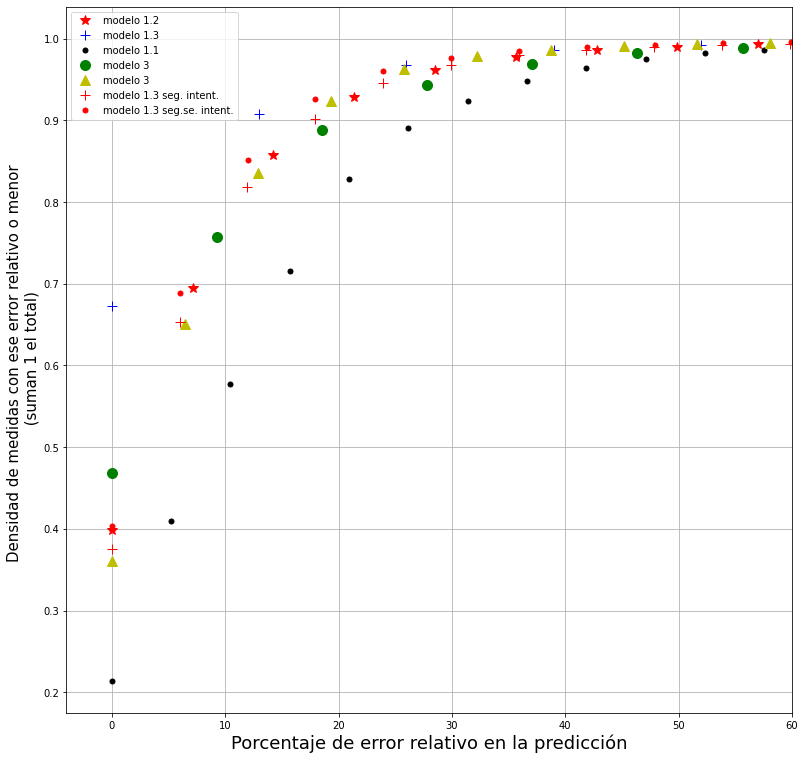

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(modelo_1_2[1][:-1],modelo_1_2[0],"*r",label="modelo 1.2",markersize=10)
plt.plot(model0_1_3[1][:-1],model0_1_3[0],"+b",label="modelo 1.3",markersize=10)
plt.plot(modelo_1[1][:-1],modelo_1[0],".k",label="modelo 1.1",markersize=10)
plt.plot(modelo_3_tl[1][:-1],modelo_3_tl[0],"og",label="modelo 3",markersize=10)
plt.plot(modelo_2[1][:-1],modelo_2[0],"^y",label="modelo 3",markersize=10)
plt.plot(modelo_1_3_segundointento[1][:-1],modelo_1_3_segundointento[0],"+r",label="modelo 1.3 seg. intent.",markersize=10)
plt.plot(datos_hist[1][:-1],datos_hist[0],".r",label="modelo 1.3 seg.se. intent.",markersize=10)

datos_hist
plt.legend()
plt.xlim([-4,60])
plt.grid()
plt.xlabel("Porcentaje de error relativo en la predicción",fontsize=18)
plt.ylabel("Densidad de medidas con ese error relativo o menor \n (suman 1 el total)",fontsize=15)

EL MODELO 1.2 CON MAS COMPLEJIDAD ES NOTABLEMENTE MEJOR